In [4]:
# Numerical Libraries
import numpy as np
import pandas as pd
import scipy
# Standard
import datetime, time, math, random
# Data Import Libraries
import yfinance as yf
import pandas_datareader as pdr
import pandas_datareader.data as web
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')
# QP Optimization
import cvxpy as cvx
# We calculate the p-value of the coefficients using the statsmodels.api Linear Regression Model
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import chi2
from scipy.stats.stats import pearsonr
import statsmodels.api as sm
# Distributions, Optimizations
from scipy.stats import uniform, norm
# Utility Programs
from pathlib import Path
import os, pickle
# Hidden Markov Models and PGMPY
from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.estimators import BicScore
from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator, TreeSearch
from pgmpy.estimators import BayesianEstimator, K2Score, BDeuScore, BDsScore
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.readwrite import BIFReader
# SK-Learn - Machine Learning
from sklearn import metrics
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report
# Plots
import seaborn as sns
import networkx as nx
from pylab import plt, mpl
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

plt.style.use('ggplot')  # or another built-in style like 'fivethirtyeight'

mpl.rcParams['font.family'] = 'serif'

In [12]:
# Function to get simple stock prices from Yahoo. Input stock code as in Yahoo URL and Start/End Date YYYY-MM-DD
def GetQuotes(S, Start, End):
    '''
    S: List/Iterable of Stock Quotes as in Yahoo URL for Download e.g MSFT for Microsoft
    Start: Date in YYYY-MM-DD
    End: Date in YYYY-MM-DD
    '''
    Prices = []
    t1 = int(pd.to_datetime(Start).timestamp())
    t2 = int(pd.to_datetime(End).timestamp())
    for i in S:
        URL = 'https://query1.finance.yahoo.com/v7/finance/download/'+i + '?period1=' + str(int(t1)) + '&period2='+ str(int(t2)) + '&interval=1d&events=history&includeAdjustedClose=true'
        Stock_DF = pd.read_csv(URL, header = 0, encoding = 'utf-8')
        Date_DT = pd.to_datetime(Stock_DF['Date'])
        Stock_DF.insert(1,'DateTime', Date_DT, allow_duplicates = False)
        Stock_DF = Stock_DF.drop(['Date'], axis=1).set_index('DateTime')
        Prices.append(Stock_DF)
    return Prices

In [14]:
def GetAdjCloseQuotes(S, Start, End):
    '''
    S: List/Iterable of Stock Quotes as in Yahoo URL for Download e.g MSFT for Microsoft
    Start: Date in YYYY-MM-DD
    End: Date in YYYY-MM-DD
    '''
    P = GetQuotes(S, Start, End)
    P_DF = []
    for i in range(len(P)):
        P_DF.append(pd.DataFrame(P[i]['Adj Close'].values, index = P[i].index, columns = [S[i]]))
    return P_DF[0].join(P_DF[1:], how = 'inner')
def ReturnsPerClose(DF):
    DF_Arr = DF.values
    DF_Ret = np.log(DF_Arr[1:]) - np.log(DF_Arr[:-1])
    return pd.DataFrame(DF_Ret, index = DF.index[1:], columns = DF.columns)
def ReturnsPerDay(DF):
    DF_Arr = DF.values
    Days_Diff = DF.index[1:] - DF.index[:-1]
    Days = np.array([i.days for i in Days_Diff])
    Log_Returns = (np.log(DF_Arr[1:]) - np.log(DF_Arr[:-1]))/Days.reshape(-1,1)
    Log_Returns_DF = pd.DataFrame(Log_Returns, index = DF.index[1:], columns = DF.columns)
    Log_Returns_DF.insert(0,'Days', Days, allow_duplicates = False)
    return Log_Returns_DF
# Using code from FRED API: Get US Economic Data using Python
def get_fred_data(param_list, start_date, end_date):
    df = pdr.DataReader(param_list, "fred", start_date, end_date)
    return df.reset_index()

In [15]:
# Asset Classes: Equities (S&P500: "^SPY", UK FTSE: " ISF.L"), AI (REIT: " ESS"), Commodities (Gold, "AAAU") 
# Add MSCI Emerging Markets ETS iShares ("EEM"), Invesco Euro Currency ETF "FXE"
# Start Date: 2019-01-01,End Date: 2023-01-01 
Assets = ['AAAU', 'SPY', 'ISF.L', 'ESS', 'EEM', 'FXE']
Start_Date = "2019-01-01"
End_Date = "2023-01-01"
# High Yield Corporate Bond Data
Series = "BAMLHYH0A0HYM2TRIV"

In [ ]:
# Strategic Asset Price Series
Imp_Prices = GetAdjCloseQuotes(Assets, Start_Date, End_Date)

In [ ]:
# Get Data for Bond Total Index Series
Bond_IDX = get_fred_data(param_list=[Series], start_date=Start_Date, end_date=End_Date).set_index('DATE')
# Join the Bond Index Data with Other Assets (Goldman Sachs GOLD ETF, FTSE, Essex REIT Index and S&P 500)
SPDR_DF_ = Imp_Prices.join(Bond_IDX, how = 'inner').rename(columns = {'BAMLHYH0A0HYM2TRIV':'BofA'}).dropna()

In [ ]:
SPDR_DF_.to_csv(Path('C:/MScFE/Capstone/General/Bond_IDX2.csv'))

<b>Execute below only IF reading from a local file containing the data for the 5 Asset Classes. Else Ignore</b>

In [5]:
SPDR_DF_ = pd.read_csv('C:/MScFE/Capstone/General/Bond_IDX2.csv').rename(columns = {'Unnamed: 0':'Date'})
# Convert the 'Date' Field to 'Pandas.Datetime' Object and append into DataFrame
SPDR_Date = pd.to_datetime(SPDR_DF_['Date'])
# Append the column into the DataFrame just after the Date' column
SPDR_DF_.insert(1,'DateTime', SPDR_Date, allow_duplicates = False)
SPDR_DF_ = SPDR_DF_.drop(['Date'], axis=1).set_index('DateTime')
SPDR_DF_.head()

,AAAU,SPY,ISF.L,ESS,EEM,FXE,BofA
DateTime,,,,,,,
2019-01-02,13.05,234.061615,665.400024,209.002655,35.878632,108.272728,1234.57
2019-01-03,12.93,228.476242,661.000000,210.106903,35.228130,108.741997,1236.01
2019-01-04,12.84,236.129227,674.599976,210.513260,36.364223,108.761963,1249.58
2019-01-07,12.88,237.990997,672.700012,211.387802,36.446682,109.480858,1259.24
2019-01-08,12.85,240.227066,677.500000,216.670532,36.584106,109.141380,1265.77


In [6]:
# Split into Training and Testing
SPDR_DF_T = SPDR_DF_[SPDR_DF_.index.year>2021]
SPDR_DF = SPDR_DF_[SPDR_DF_.index.year<2022]

In [6]:
pd.DataFrame({'Training':len(SPDR_DF), 'Testing':len(SPDR_DF_T),'All Data': len(SPDR_DF_)},
            index = ['Sample Size'])

,Training,Testing,All Data
Sample Size,744,243,987


In [7]:
pd.DataFrame({'Training':np.array([SPDR_DF.index[0], SPDR_DF.index[-1]]),
              'Testing':np.array([SPDR_DF_T.index[0], SPDR_DF_T.index[-1]]),
              'All Data':np.array([SPDR_DF_.index[0], SPDR_DF_.index[-1]])},index = ['Start', 'Date'])

,Training,Testing,All Data
Start,2019-01-02,2022-01-04,2019-01-02
Date,2021-12-31,2022-12-30,2022-12-30


In [7]:
SPDR_R_DF = ReturnsPerClose(SPDR_DF)
Days_Y = 252
SPDR_R_C = SPDR_R_DF.corr()

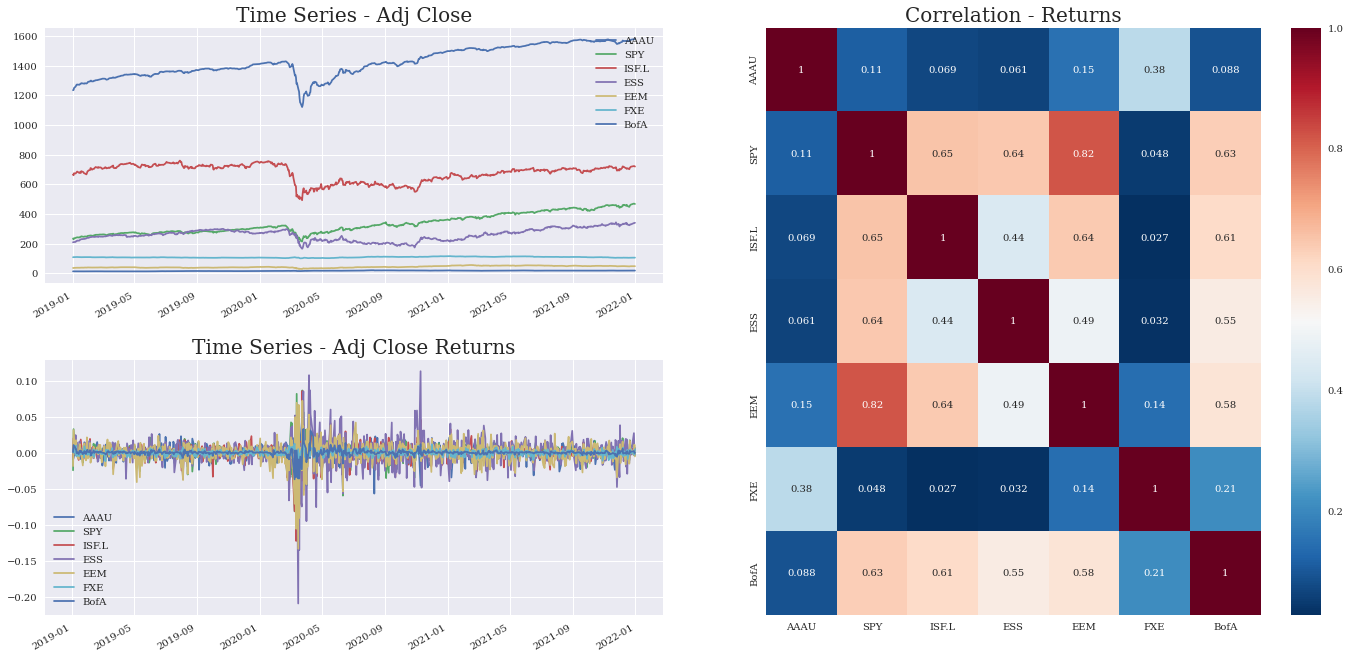

In [17]:
fig = plt.figure(figsize=(24, 12))
grid = plt.GridSpec(2, 4, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0, :2])
ax2 = plt.subplot(grid[1, :2])
ax3 = plt.subplot(grid[0:, 2:])

SPDR_DF.plot.line(ax= ax1)
ax1.set_title("Time Series - Adj Close", fontsize=20)
SPDR_R_DF.plot.line(ax= ax2)
ax2.set_title("Time Series - Adj Close Returns", fontsize=20)
sns.heatmap(SPDR_R_C, cmap="RdBu_r", ax=ax3, annot = True)
ax3.set_title("Correlation - Returns", fontsize=20)
plt.show()

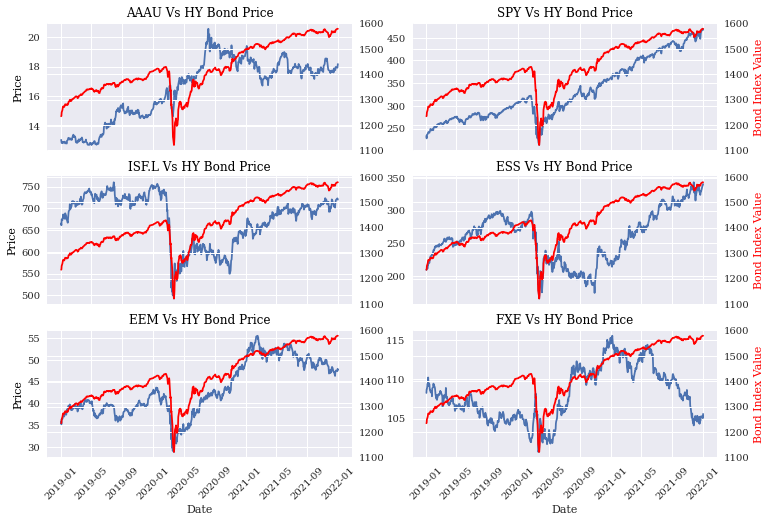

In [20]:
# Plot Prices for Gold, FTSE 100, REIT and S&P 500 (Risky Assets) Vs Corporate BOND Index
fig, ax = plt.subplots(3,2, figsize = (12,8), sharex = True)
for i in range(3):
    for j in range(2):
        ax[i,j].tick_params('x',labelrotation=45)
        ax[i,j].plot(SPDR_DF.index, SPDR_DF[Assets[2*(i)+j]])
        ax2 = ax[i,j].twinx()
        ax2.plot(SPDR_DF.index, SPDR_DF['BofA'], color = 'red')
        if j ==1:
            ax2.set_ylabel('Bond Index Value', color = 'red')
        if i==2:
            ax[i,j].set_xlabel('Date')
        if j ==0:
            ax[i,j].set_ylabel('Price', color = 'black')
        ax[i,j].set_title(Assets[2*(i)+j] + ' Vs HY Bond Price', color = 'black')
plt.show()

In [8]:
Period = (SPDR_DF.index[-1] - SPDR_DF.index[0]).days/365
SPDR_ER = SPDR_R_DF.mean(axis = 0)
SPDR_STD = SPDR_R_DF.std(axis = 0)
# Get Expected Return (Annual) and Volatility Standard Deviation of Returns Per Close
ER = SPDR_R_DF.sum(axis = 0)/Period
#D5_STD = SPDR_STD
Y_STD = SPDR_STD*math.sqrt(Days_Y)
# Daily Covariance
COV = SPDR_R_DF.cov().values
# Annual Covariance
COVA = COV*Days_Y

In [12]:
pd.DataFrame([ER.values, Y_STD.values], index=["Annualized Return", "Volatility Annualized"], columns = ER.index)

,AAAU,SPY,ISF.L,ESS,EEM,FXE,BofA
Annualized Return,0.110612,0.230728,0.026265,0.162826,0.095095,-0.008349,0.082054
Volatility Annualized,0.155967,0.221970,0.199674,0.334181,0.242821,0.062393,0.070902


<b>Dirichlet Distribution</b><br>
The 'Dirichlet Distribution' is used to generate random weights, these are all long weights. However the program can be simulated to get short weights and add constraints. This is useful for Monte Carlo simulation.

In [12]:
# Helper Functions - Generate Random Weights - Non Redundant
def LongWeights(n, N):
    '''
    n: (int) Number of Assets
    N: (int) Number of Weight Vectors
    '''
    Rand = np.random.dirichlet(tuple(1 for i in range(n)),N)
    return Rand

In [13]:
def PRisk(C):
    '''
    W: Weights for Assets (N*1)
    C: Covariance of Asset Returns (N*N) 
    Number of Columns of DataFrame match the Number of Weights
    '''
    def RR(W):
        return np.sum(np.sqrt(np.matmul(np.matmul(W.T, C),W)))
    return RR

In [13]:
# Combined Function for Risk-Returns and Weights
def PortfolioRR3(r,COV,n):
    '''
    r: Vector of Asset Returns (N,)
    COV: Covariance of Asset Returns (N*N)
    n: Number of Partitions + 1 for Weights for Each Asset > 1
    '''
    P_Var_L = []
    P_Ret_L = []
    a = len(r)
    nW = WeightsA(a,[n for i in range(a)])
    P = PRisk(COV)
    for i in nW:
        A = P(np.array(i))
        P_Var_L.append(A)
        P_Ret_L.append(np.sum(np.array(i)*r))
    return (P_Var_L,P_Ret_L, nW)

In [9]:
def MinVarPort(S,R,W):
    '''
    S: Standard Deviations in Iterable
    R: Return
    W: Weights as Iterable
    Length is Same. Performance can be improved by only picking the Minimum Variance
    '''
    RRW = sorted([(S[i],R[i],W[i]) for i in range(len(S))], key = lambda t: t[0])[0]
    return RRW
def MinVarPortv(S,R,W):
    '''
    S: Standard Deviations in Iterable
    R: Risk
    W: Weights as Array.(Shape is Sample Size * Sample Length)
    Size of Weight Array and Lengths of S,R are same. Performance can be improved by only picking the Minimum Variance
    '''
    RRW = sorted([(S[i],R[i],W[i,:]) for i in range(len(S))], key = lambda t: t[0])[0]
    return RRW
def NoRebalance(R, w, A):
    '''
    R: DataFrame/Array. M*N logarithmic returns. M Days and N Assets
    w: Array. N*1 weights for N assets
    A: Float. Intial Investment
    '''
    ER = R.cumsum(axis = 0)
    return pd.DataFrame(A*np.matmul(np.exp(ER).values, w), index = R.index, columns = ['Price'])
def DailyRebalance(R, w, A):
    '''
    R: DataFrame/Array. M*N logarithmic returns. M Days and N Assets
    w: Array. N*1 weights for N assets
    A: Float. Intial Investment
    '''
    return pd.DataFrame(A*np.matmul(np.exp(R.values), w).cumprod(), index = R.index, columns = ['Price'])
def DailyRebalanceP(P, w, A):
    '''
    P: DataFrame/Array. M*N Prices. M Days and N Assets
    w: Array. N*1 weights for N assets
    A: Float. Intial Investment
    '''
    R = ReturnsPerClose(P)
    return pd.DataFrame(A*np.matmul(np.exp(R.values), w).cumprod(), index = P.index, columns = ['Price'])
def RebalanceT(R,w,n,A):
    '''
    R: DataFrame/Array. M*N logarithmic returns. M Days and N Assets
    w: Array. N*1 weights for N assets
    n: Integer. Days of Buy-Hold
    A: Float. Intial Investment
    '''
    M, N = R.shape
    Value = np.zeros((M+1,1))
    Value[0,0] = A
    T = M//n
    S = M - T*n
    for i in range(T):
        ER = R.values[i*n:i*n + n,:].cumsum(axis = 0)
        Value[i*n + 1:i*n + n + 1,:] = Value[i*n,0]*np.matmul(np.exp(ER), w)
    if S > 0:
        ER = R.values[T*n:,:].cumsum(axis = 0)
        Value[T*n + 1:,:] = Value[T*n,0]*np.matmul(np.exp(ER), w)
    return pd.DataFrame(Value[1:,], index = R.index, columns = ['Price'])

In [10]:
# Dirichlet Distribution for Weights
def PortfolioRRv(D,w):
    '''
    w: Weights for Assets. (Shape is Sample Size * Sample Length)
    D: DataFrame of Returns, DateTime Index. 
    Number of Columns of DataFrame match the Sample Length of Weights
    '''
    Days_Y = 252
    P_Var_L = []
    P_Ret_L = []
    Period = (D.index[-1] - D.index[0]).days/365
    D_ER = D.sum(axis = 0)/Period
    COVAR = D.cov().values
    for i in range(w.shape[0]):
        wi = w[i,:] 
        W = wi.reshape(1,-1)
        WT = W.T
        WWT = np.matmul(WT,W)
        A = WWT*COVAR
        P_Var_L.append(math.sqrt(np.sum(A)))
        P_Ret_L.append(np.sum(wi*D_ER))
    A_STD_RR = np.array(P_Var_L)*math.sqrt(Days_Y)
    return A_STD_RR, P_Ret_L

In [11]:
def CVXeFrontier(R, COVA, r):
    '''
    R: Asset Indexed Vector of Returns (Annual). Length (N,). N is Assets
    COVA: DataFrame of Covariances (Annual). Columns are a subset of N Assets
    r: Tuple/List of Float. Range of Returns. Min-Max
    '''
    r_Returns, L = np.arange(r[0],r[1],0.01),list(COVA.columns)
    Asset_R, N, COVA_ = R[L], COVA.shape[0], COVA.values
    P_Weights = []
    P_Returns = []
    P_Volatility = []
    for i in r_Returns:
        G = np.zeros((N,N))
        np.fill_diagonal(G,-1)
        h = np.array([0 for i in range(N)])
        A = np.ones((2,N))
        A[1:,] = Asset_R
        b = np.array([1,i])
        Asset_R_ = np.array(Asset_R).reshape(-1,1)
        x = cvx.Variable(N)
        Prob = cvx.Problem(cvx.Maximize((-1/2)*cvx.quad_form(x, COVA_)),[G @ x <= h,A @ x == b])
        Prob.solve()
        if x.value is not None:
            x_values = x.value.reshape(-1,1)
            P_Weights.append((x_values,L))
            P_Returns.append(np.sum(np.dot(x.value,Asset_R)))
            P_Volatility.append(np.sqrt(np.sum(np.matmul(x_values,x_values.T)*COVA_)))
    return P_Weights, P_Returns, P_Volatility

In [12]:
def CVXeP(R, COVA, r):
    '''
    R: Asset Indexed Vector of Returns (Annual). Length (N,). N is Assets
    COVA: DataFrame of Covariances (Annual). Columns are a subset of N Assets
    r: Tuple/List of Float. Range of Returns. Min-Max
    '''
    r_Returns, L = list(r),list(COVA.columns)
    Asset_R, N, COVA_ = R[L], COVA.shape[0], COVA.values
    P_Weights = []
    P_Returns = []
    P_Volatility = []
    for i in r_Returns:
        G = np.zeros((N,N))
        np.fill_diagonal(G,-1)
        h = np.array([0 for i in range(N)])
        A = np.ones((2,N))
        A[1:,] = Asset_R
        b = np.array([1,i])
        Asset_R_ = np.array(Asset_R).reshape(-1,1)
        x = cvx.Variable(N)
        Prob = cvx.Problem(cvx.Maximize((-1/2)*cvx.quad_form(x, COVA_)),[G @ x <= h,A @ x == b])
        Prob.solve()
        if x.value is not None:
            x_values = x.value.reshape(-1,1)
            P_Weights.append((x_values,L))
            P_Returns.append(np.sum(np.dot(x.value,Asset_R)))
            P_Volatility.append(np.sqrt(np.sum(np.matmul(x_values,x_values.T)*COVA_)))
    return P_Weights, P_Returns, P_Volatility

In [14]:
EffPortCVX = CVXeP(ER, SPDR_R_DF.cov()*Days_Y, [0.12,0.17,0.22])

In [20]:
W5_D = LongWeights(7, 100_000)
A_STD_RRv, PRRv_Ret = PortfolioRRv(SPDR_R_DF,W5_D)
MinVar = MinVarPortv(A_STD_RRv,PRRv_Ret,W5_D)

In [21]:
CVXCombine = CVXeFrontier(ER, SPDR_R_DF.cov()*Days_Y, (np.min(ER), np.max(ER)))

In [22]:
MinVarCVX = MinVarPort(CVXCombine[2], CVXCombine[1], CVXCombine[0])

In [67]:
pd.DataFrame(np.round(MinVarCVX[2][0],2), index = ER.index, columns = ['Minimum Variance Portfolio Weights']).T

,AAAU,SPY,ISF.L,ESS,EEM,FXE,BofA
Minimum Variance Portfolio Weights,0.01,-0.0,-0.0,-0.0,-0.0,0.56,0.43


In [27]:
# Tangent Portfolio - Highest Sharpe Ratio
SharpeR_L =[(CVXCombine[1][i]-0.02)/CVXCombine[2][i] for i in range(len(CVXCombine[0]))]
TangentP_ = SharpeR_L.index(max(SharpeR_L))
# Sharpe Ratio of Tangential Portfolio
pd.DataFrame(np.round(CVXCombine[0][TangentP_][0],2), index = ER.index, columns = ['Tangent MVO Portfolio Weights']).T

,AAAU,SPY,ISF.L,ESS,EEM,FXE,BofA
Tangent MVO Portfolio Weights,0.25,0.22,-0.0,-0.0,-0.0,-0.0,0.53


In [26]:
CVXCombine[0][TangentP_][0].shape

(7, 1)

In [31]:
pd.DataFrame({'Minimum Variance Portfolio':np.round(np.array((MinVarCVX[1], MinVarCVX[0], (MinVarCVX[1]-0.02)/(MinVarCVX[0]))),4),
             'Tangent MVO Portfolio':np.round(np.array((CVXCombine[1][TangentP_], CVXCombine[2][TangentP_], SharpeR_L[TangentP_])),4)},
             index = ['Return', 'Annualized Volatility', 'SR']).T

,Return,Annualized Volatility,SR
Minimum Variance Portfolio,0.0317,0.0514,0.2266
Tangent MVO Portfolio,0.1217,0.0910,1.1169


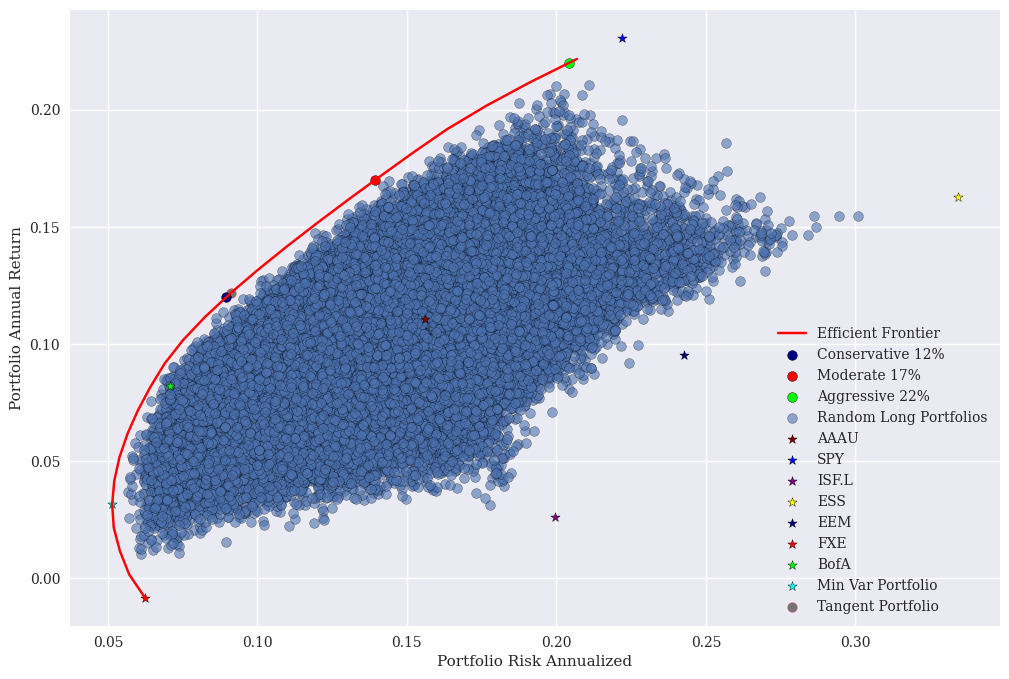

In [31]:
# Plots
colors = ['maroon', 'blue', 'purple', 'yellow', 'navy', 'red', 'lime', 'cyan', 'orange', 'gray']
plt.figure(figsize = (12,8))
plt.plot(CVXCombine[2],CVXCombine[1], color = 'r')
for i in range(len(EffPortCVX)):
    plt.scatter(EffPortCVX[2][i], EffPortCVX[1][i], marker = 'o', facecolor = colors[i+4], edgecolor = 'k')
plt.scatter(A_STD_RRv, PRRv_Ret, edgecolor = 'k', alpha = 0.6)
for i in range(len(SPDR_DF.columns)):
    plt.scatter(Y_STD[i], ER[i], marker = '*', facecolor = colors[i], edgecolor = 'k')
plt.scatter(MinVarCVX[0], MinVarCVX[1], marker = '*', facecolor = 'cyan', edgecolor = 'k')
plt.scatter(CVXCombine[2][TangentP_], CVXCombine[1][TangentP_], marker = 'o', facecolor = 'black', edgecolor = 'r', alpha = 0.5)
plt.legend(['Efficient Frontier','Conservative 12%','Moderate 17%','Aggressive 22%','Random Long Portfolios']+list(SPDR_DF.columns)+['Min Var Portfolio', 'Tangent Portfolio'])
plt.xlabel('Portfolio Risk Annualized')
plt.ylabel('Portfolio Annual Return')
plt.show()

<b>Validation</b><br>
BackTesting | <i>Walkforward</i> Validation in Training

In [15]:
def TangentCLAOpt(R, C):
    '''
    R: Vector of Holding Period Returns (Year/Daily)
    C: Covariances Holding Period (Year/Daily)
    Returns Weights (Vector), Return, Volatility and Sharpe Ratio of Tangent Portfolio
    '''
    T_CLA = CLA(R, C)
    T_CLA.max_sharpe()
    return T_CLA.weights.reshape(-1,1), T_CLA.portfolio_performance(verbose=False)

In [16]:
def TangentOpt(ER, C):
    '''
    R: Vector of Holding Period Returns (Year/Daily)
    C: DataFrame of Covariances Holding Period (Year/Daily)
    Returns Weights (Vector), Return, Volatility and Sharpe Ratio of Tangent Portfolio
    '''
    CVXCombine = CVXeFrontier(ER, C, (np.min(ER), np.max(ER)))
    SharpeR_L =[(CVXCombine[1][i]-0.02)/CVXCombine[2][i] for i in range(len(CVXCombine[0]))]
    TangentP_ = SharpeR_L.index(max(SharpeR_L))
    RR_SR = CVXCombine[1][TangentP_], CVXCombine[2][TangentP_],SharpeR_L[TangentP_]
    return CVXCombine[0][TangentP_][0], RR_SR

In [17]:
# This function just tests using a rolling period of Training and Output a DataFrame with Weights for each Test
# The KPI we use are in-sample Return, Variance and Sharpe Ratio
def BackTestOpt(L, Price):
    '''
    L: Days of Lags
    P: Daily Price. Index should have DateTime
    '''
    Period = (Price.index[-1] - Price.index[0]).days/365
    Returns_DF = ReturnsPerClose(Price)
    Returns = Returns_DF.values
    Portfolio_Opt = {"Return" : [],"Volatility": [],"Sharpe Ratio": []}
    Columns = list(Price.columns)
    Names = {i : [] for i in Columns}
    Portfolio_Opt.update(Names)
    for i in range(Returns.shape[0] - L + 1):
        R = Returns[i:i+L,]
        C = Returns_DF.cov()*252
        YR = Returns_DF.iloc[i:i+L,].sum(axis = 0)/L*252
        T_ = TangentOpt(YR, C)
        for i in range(len(Columns)):
            Portfolio_Opt[Columns[i]] += [T_[0][i,0]]
        Portfolio_Opt['Return'].append(T_[1][0])
        Portfolio_Opt['Volatility'].append(T_[1][1])
        Portfolio_Opt['Sharpe Ratio'].append(T_[1][2])
    return pd.DataFrame(Portfolio_Opt)
def WalkForwardOpt(L, Price):
    '''
    L: Days for Training. Ideally should be 120 Days, or 1/2 of (M) in Price
    T: Days for Test
    P: Daily Price. M (Days)*N (Assets)
    '''
    Returns_DF = ReturnsPerClose(Price)
    Returns = Returns_DF.values
    Weights, Real_SR = [], []
    for i in range(Returns.shape[0] - L - 30 + 1):
        R = Returns[i:i+L,]
        C = Returns_DF.cov()*252
        YR = Returns_DF.iloc[i:i+L,].sum(axis = 0)/L*252
        T_ = TangentOpt(YR, C)
        Weights.append(T_[0])
        Forward_Prices = NoRebalance(Returns_DF.iloc[i+L:i+L+30,:], T_[0], 100)
        WF_Returns = ReturnsPerClose(Forward_Prices)
        Mu = WF_Returns['Price'].mean()*Days_Y
        STD = WF_Returns['Price'].std()*Days_Y**0.5
        Real_SR.append(np.sum((Mu - 0.02)/STD))
    return Weights, Real_SR

In [35]:
BackTest_Portfolio_DF = BackTestOpt(500,SPDR_DF)

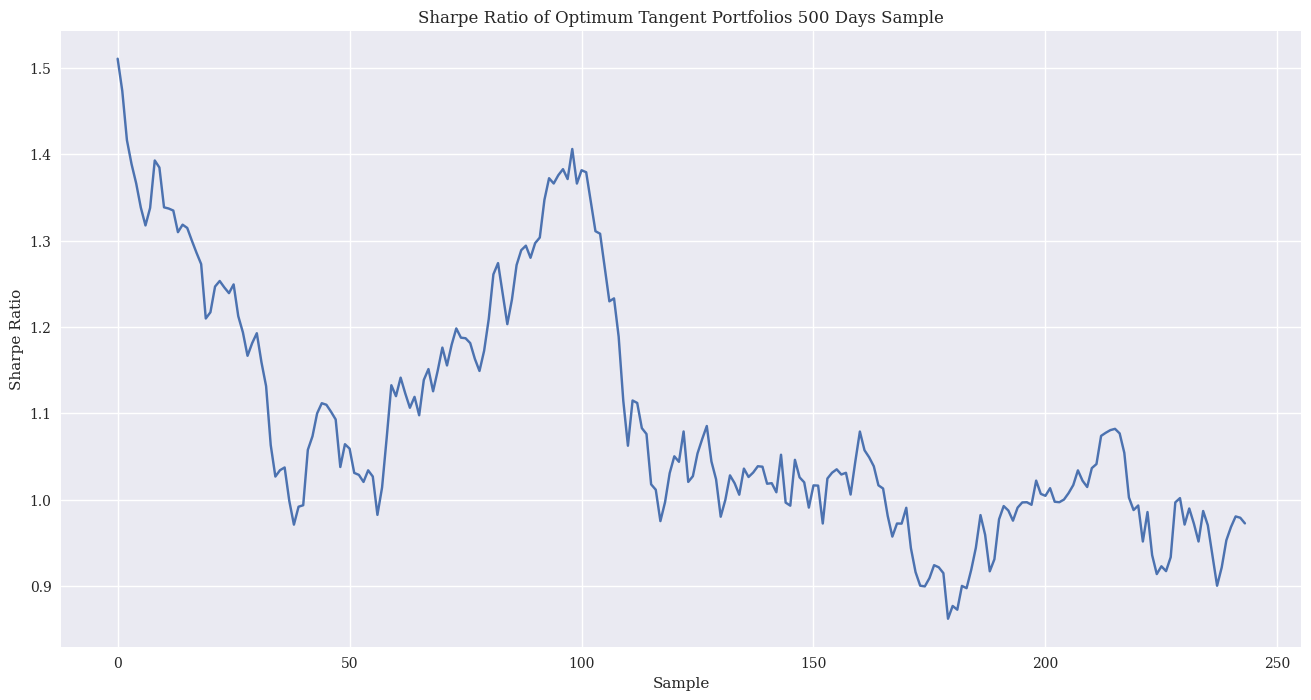

In [36]:
plt.figure(figsize=(16,8))
plt.plot(BackTest_Portfolio_DF['Sharpe Ratio'])
plt.xlabel('Sample')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio of Optimum Tangent Portfolios 500 Days Sample')
plt.show()

In [61]:
# We can take a Mean of All Optimum Portfolios (Tangent) using above Backtested using 500 Days per Sample
pd.DataFrame(np.round(BackTest_Portfolio_DF[ER.index].mean(),3), columns = ['252 Days Rolling Optimized Weights']).T

,AAAU,SPY,ISF.L,ESS,EEM,FXE,BofA
252 Days Rolling Optimized Weights,0.375,0.339,0.0,0.0,0.0,0.0,0.286


In [19]:
# Perform Backtest using Rolling Forward - Testing Out-of-Sample
Test = WalkForwardOpt(500, SPDR_DF)

In [35]:
Test[0][0].ravel()

array([3.25520254e-01, 6.95706330e-02, 1.03276566e-22, 1.31531406e-22,
       5.41419602e-23, 3.24040453e-23, 6.04909112e-01])

In [40]:
WalkF_W_DF = pd.DataFrame(index = ER.index)
for i in range(len(Test[0])):
    WalkF_W_DF.insert(0,i, Test[0][i].ravel())

In [43]:
# We can take a Mean of All Optimum Portfolios (Tangent) using above WalkForward using 500 Days per Sample
pd.DataFrame(np.round(WalkF_W_DF.mean(axis =1),3), columns = ['500 Days WalkForward Weights']).T

,AAAU,SPY,ISF.L,ESS,EEM,FXE,BofA
500 Days WalkForward Weights,0.371,0.31,0.0,0.0,0.0,0.0,0.319


In [43]:
# Mean Sharpe Ratio (OOS - 30 Days of Test Data)
pd.DataFrame((SharpeR_L[TangentP_], sum(Test[1])/len(Test[1])), index = ['Tangent MVO', 'Backtesting Optimized'], columns =['Sharpe Ratio']).T

,Tangent MVO,Backtesting Optimized
Sharpe Ratio,1.116901,0.936892


In [45]:
WalkF_Portfolio = Test[0][Test[1].index(max(Test[1]))]
pd.DataFrame(np.round(WalkF_Portfolio.reshape(1,-1),3), 
             index = ['Backtesting Optimized Portfolio Weights'], columns = ER.index)

,AAAU,SPY,ISF.L,ESS,EEM,FXE,BofA
Backtesting Optimized Portfolio Weights,0.242,0.453,-0.0,-0.0,-0.0,-0.0,0.305


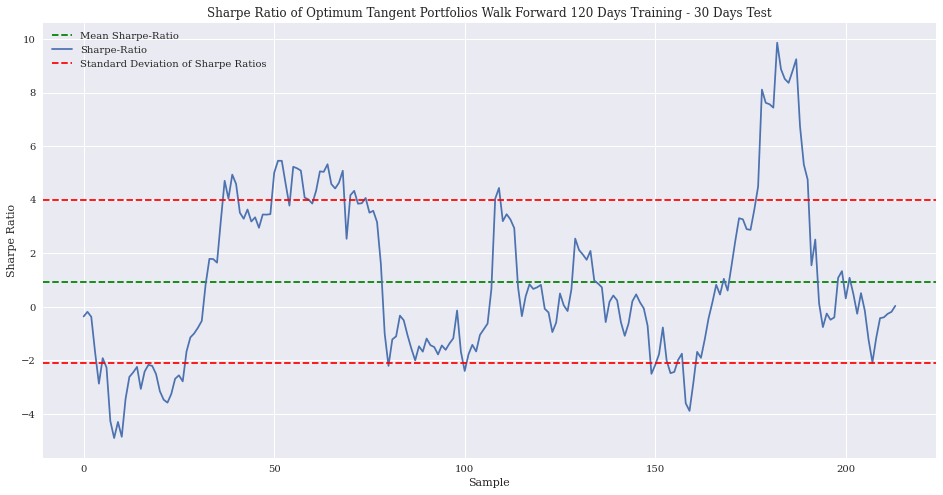

In [46]:
plt.figure(figsize=(16,8))
plt.axhline(sum(Test[1])/len(Test[1]), color = 'g', linestyle = '--')
plt.plot(Test[1])
plt.axhline(sum(Test[1])/len(Test[1]) + np.std(Test[1]), color = 'r', linestyle = '--')
plt.axhline(sum(Test[1])/len(Test[1]) - np.std(Test[1]), color = 'r', linestyle = '--')
plt.xlabel('Sample')
plt.ylabel('Sharpe Ratio')
plt.legend(['Mean Sharpe-Ratio','Sharpe-Ratio', 'Standard Deviation of Sharpe Ratios'])
plt.title('Sharpe Ratio of Optimum Tangent Portfolios Walk Forward 120 Days Training - 30 Days Test')
plt.show()

<b>Risk Management System - Tactical Asset Allocation</b>

In [40]:
# Download from St Louis Federal Reserve Bank: https://fred.stlouisfed.org/series/WTISPLC
Tickers = ['^BSESN','000001.SS','ISF.L', 'ESS', '^GSPC', 'GOLD.AX']
S_Date = "2009-01-01"
#End_Date = "2023-01-01"

In [76]:
# Use YFinance over Proxy. If there is no Proxy then remove 'proxy' parameter
Data_ = yf.download(Tickers, start=S_Date, end=End_Date,
                   group_by="ticker", proxy = 'http://127.0.0.1:10809')

[*********************100%***********************]  6 of 6 completed


In [77]:
Imp_Prices = pd.DataFrame(Data_[(Tickers[0],'Adj Close')].values, index = Data_.index, columns = [Tickers[0]])
for i in Tickers[1:]:
    Imp_Prices.insert(len(Imp_Prices.columns), i, Data_[(i,'Adj Close')],allow_duplicates = False)

In [79]:
Imp_Prices.head()

,^BSESN,000001.SS,ISF.L,ESS,^GSPC,GOLD.AX
Date,,,,,,
2008-12-31,9647.309570,NaN,442.735992,48.537148,903.250000,NaN
2009-01-02,9958.219727,NaN,458.500000,47.417801,931.799988,124.330002
2009-01-05,10275.599609,1880.715942,460.250000,47.316605,927.450012,120.639999
2009-01-06,10335.929688,1937.145020,465.500000,48.239910,934.700012,118.199997
2009-01-07,9586.879883,1924.011963,451.500000,47.272350,906.650024,117.660004


In [ ]:
Imp_Prices = GetAdjCloseQuotes(Tickers, S_Date, End_Date)

In [80]:
Imp_Prices.to_csv(Path('C:/MScFE/Capstone/General/Imp_Prices.csv'))

In [18]:
Combine_DF = pd.read_csv('C:/MScFE/Capstone/General/Imp_Prices.csv')
# Convert the 'Date' Field to 'Pandas.Datetime' Object and append into DataFrame
Date2_ = pd.to_datetime(Combine_DF['Date'])
# Append the column into the DataFrame just after the Date' column
Combine_DF.insert(1,'DateTime', Date2_, allow_duplicates = False)
Combine_DF = Combine_DF.drop(['Date'], axis=1).set_index('DateTime')

In [ ]:
Crude_P = get_fred_data(param_list='WTISPLC', start_date=S_Date, end_date=End_Date).set_index('DATE')
Gold_P = get_fred_data(param_list='IQ12260', start_date=S_Date, end_date=End_Date).set_index('DATE')
# Get Data for Macroeconomic Index Series. We drop NaN. Since missing data can't be simply imputed
# https://fred.stlouisfed.org/series/GVZCLS Gold ETF Volatility Index
Macro_S = ['DFF', 'DFII10', 'T5YIE', 'GVZCLS']
Macro_IDX = get_fred_data(param_list=Macro_S, start_date=S_Date, end_date=End_Date).set_index('DATE').dropna()
# Microeconomic Price Series
# Extract API Key: Put Your Key in Angle Brackets <>
myKey = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
fred_api_key = "<75614e192d7c2860f42a90dd9447019a>"
# Let's see what the Bond Index was since 2000. # Series = "BAMLHYH0A0HYM2TRIV"
# Get Data for Bond Total Index Series
Bond_IDX = get_fred_data(param_list=[Series], start_date=S_Date, end_date=End_Date).set_index('DATE')
# Join the Bond Index Data with Other Assets (Goldman Sachs GOLD ETF, FTSE, Essex REIT Index and S&P 500)
Bond_IDX = Bond_IDX.join(Combine_DF, how = 'inner').rename(columns = {'000001.SS':'China_EQ'}).dropna()
# Get Data for Geopolitical Indices/Series
GeoP_S = ['CIVPART', 'PAYEMS', 'UNRATE','USACPICORMINMEI']
GeoP_IDX = get_fred_data(param_list=GeoP_S, start_date=S_Date, end_date=End_Date).set_index('DATE')
Gold_ETF_VIX = Macro_IDX.iloc[:,3].pct_change()
# Append the column into the DataFrame just after the 'T5YIE' column
Macro_IDX.insert(3,'GOLD_VIX', Gold_ETF_VIX, allow_duplicates = False)
Macro_IDX = Macro_IDX.drop(['GVZCLS'], axis=1)
# Microeconomic Series has Price Values. We take Logarithmic Returns per Close to scale 'Extreme Values'. No NaN
Bond_IDX_R_DF = ReturnsPerClose(Bond_IDX)
# For GeoPolitical Data, we are interested in the change and not in the absolute values. 
# Hence a change in Labor Force Participation Rate, Employed Worker, Unemployment rate and CPI is required.
GeoP_IDX = GeoP_IDX.pct_change().dropna()
Macro_IDX = Macro_IDX.dropna()
# Fred does not have wrong values. There maybe some missing values. But there is no reason to doubt the accuracy
# However ReScaling of 'Extreme Outiers' may introduce 'Questionable' values. We Drop NaN

In [ ]:
# Microeconomic Data - Daily to Monthly(Simulated by Averaging for Month)
C_IDX = []
# Take each date 1st of Month, from Crude Oil Price DF (Monthly). Average Daily Prices for last Month for Indices
for i in Gold_P.index:
    if i.month == 1:
        C_IDX.append(Bond_IDX_R_DF.index[[j.month ==12 and j.year == i.year -1 for j in Bond_IDX_R_DF.index]])
    else :
        C_IDX.append(Bond_IDX_R_DF.index[[j.month ==i.month -1 and j.year == i.year for j in Bond_IDX_R_DF.index]])
# Macroeconomic Data - Daily to Monthly(Simulated by Averaging for Month)
M_IDX = []
# Take each date 1st of Month, from Crude Oil Price DF (Monthly). Average Daily Prices for last Month for Indices
for i in Gold_P.index:
    if i.month == 1:
        M_IDX.append(Macro_IDX.index[[j.month ==12 and j.year == i.year -1 for j in Macro_IDX.index]])
    else :
        M_IDX.append(Macro_IDX.index[[j.month ==i.month -1 and j.year == i.year for j in Macro_IDX.index]])
D_R_IDX = {i:[] for i in Bond_IDX_R_DF.columns}
R_Keys = D_R_IDX.keys()
for i in C_IDX:
    IDX_Mean = Bond_IDX_R_DF.loc[i].mean()
    for j in R_Keys:
        D_R_IDX[j].append(IDX_Mean[j])
IDX_Rm_DF = pd.DataFrame(D_R_IDX, index = Gold_P.index)
D_Macro_IDX = {i:[] for i in Macro_IDX.columns}
M_Keys = D_Macro_IDX.keys()
for i in M_IDX:
    IDX_Mean_DF = Macro_IDX.loc[i]
    IDX_Mean_DF.replace([np.inf, -np.inf], 0, inplace=True)
    IDX_Mean = IDX_Mean_DF.mean()
    for j in M_Keys:
        D_Macro_IDX[j].append(IDX_Mean[j])
Macro_m_IDX = pd.DataFrame(D_Macro_IDX, index = Crude_P.index)
CombineM_DF = IDX_Rm_DF.join([Macro_m_IDX, GeoP_IDX], how = 'inner').dropna()

In [89]:
# Run to Save to Local
CombineM_DF.to_csv(Path('C:/MScFE/Capstone/General/CombineM_DF.csv'))

In [73]:
pd.read_csv('C:/MScFE/Capstone/General/CombineM_DF.csv').head(1)

,DATE,BAMLHYH0A0HYM2TRIV,^BSESN,China_EQ,ISF.L,ESS,^GSPC,GOLD.AX,DFF,DFII10,T5YIE,GOLD_VIX,CIVPART,PAYEMS,UNRATE,USACPICORMINMEI
0,2009-02-01,0.001809,-0.014117,0.004734,-0.010349,-0.009199,-0.009056,0.005629,0.161053,1.892105,0.025263,-0.00144,0.001522,-0.005654,0.064103,0.004457


In [90]:
Bond_IDX.to_csv(Path('C:/MScFE/Capstone/General/Bond_IDX3.csv'))

In [91]:
Crude_R_DF = ReturnsPerClose(Crude_P)
Gold_R_DF = ReturnsPerClose(Gold_P)
Combine_R_DF = Crude_R_DF.join([Gold_R_DF,CombineM_DF], how = 'inner').rename(columns = {'BAMLHYH0A0HYM2TRIV':'BofA',
                                                                                        'USACPICORMINMEI':'US_CPI',
                                                                                        'IQ12260':'US_Gold_EXP'})

In [201]:
# Run to Save to Local
Combine_R_DF.to_csv(Path('C:/MScFE/Capstone/General/Combine_R_DF.csv'))

In [3]:
Combine_R_DF = pd.read_csv('C:/MScFE/Capstone/General/Combine_R_DF.csv')
# Convert the 'Date' Field to 'Pandas.Datetime' Object and append into DataFrame
Date3_ = pd.to_datetime(Combine_R_DF['DATE'])
# Append the column into the DataFrame just after the Date' column
Combine_R_DF.insert(1,'DateTime', Date3_, allow_duplicates = False)
Combine_R_DF = Combine_R_DF.drop(['DATE'], axis=1).set_index('DateTime')

In [74]:
Combine_R_DF.head(1)

,WTISPLC,US_Gold_EXP,BofA,^BSESN,China_EQ,ISF.L,ESS,^GSPC,GOLD.AX,DFF,DFII10,T5YIE,GOLD_VIX,CIVPART,PAYEMS,UNRATE,US_CPI
DateTime,,,,,,,,,,,,,,,,,
2009-02-01,-0.063804,0.053551,0.001809,-0.014117,0.004734,-0.010349,-0.009199,-0.009056,0.005629,0.161053,1.892105,0.025263,-0.00144,0.001522,-0.005654,0.064103,0.004457


In [46]:
# Original Shape
Combine_R_DF.shape

(168, 17)

In [4]:
# Use Training Years ony to sub-sample Returns and Check Correlations
Combine_R_DF_T = Combine_R_DF[Combine_R_DF.index.year < 2021]

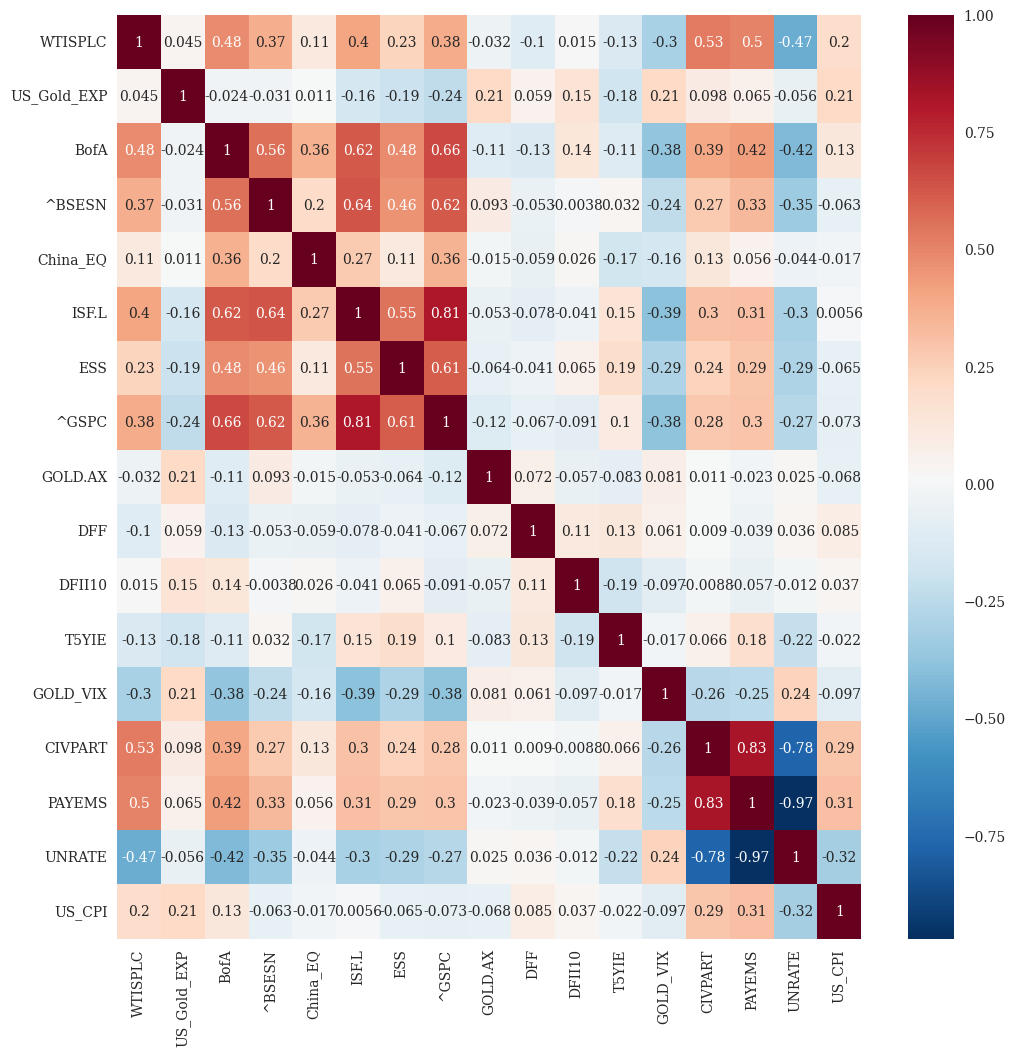

In [19]:
plt.figure(figsize=(12,12))
sns.heatmap(Combine_R_DF_T.corr(), cmap="RdBu_r", annot = True)
plt.show()

In [104]:
Combine_R_DF.describe().iloc[[1,2,3,7],].rename(index = {"mean": "Mean", "std": "Standard Deviation", "min": "Min","max": "Max"})

,WTISPLC,US_Gold_EXP,BofA,^BSESN,China_EQ,ISF.L,ESS,^GSPC,GOLD.AX,DFF,DFII10,T5YIE,GOLD_VIX,CIVPART,PAYEMS,UNRATE,US_CPI
Mean,0.003731,0.004873,0.000407,0.000571,0.000211,0.000180,0.000507,0.000473,-0.000513,0.601978,0.337864,1.793797,0.001235,-0.000298,0.000935,0.002721,0.001942
Standard Deviation,0.112529,0.038535,0.001340,0.003223,0.003417,0.002260,0.003668,0.002640,0.010341,0.834519,0.738875,0.505232,0.008348,0.004124,0.011235,0.186045,0.002012
Min,-0.568125,-0.100188,-0.005941,-0.014117,-0.014267,-0.010349,-0.011574,-0.009056,-0.129597,0.048571,-1.065455,0.025263,-0.013657,-0.039936,-0.135905,-0.176471,-0.004575
Max,0.545621,0.127280,0.006164,0.013310,0.009936,0.007547,0.012381,0.007308,0.006981,4.091905,1.892105,3.410870,0.037656,0.011647,0.034309,2.340909,0.008427


In [105]:
# Models require Time Series (time-indexed random variable) to be Stationary. 
# ADF on Price Series. P-Value = 0.89 > 0.01/0.05. Hence cannot reject NULL Hypothesis that Series is Non-Stationary
# Or Test Statistic -0.50 is NOT LESS THAN critical values (-3.44/-2.87) at 1%/5% significance
# adfuller(Join_DF[Tickers[0]], maxlag = 15)
# Jarque Bera Test is not performed as it needs a larger sample >2000. But we can calculate Skew and Kurtosis
def ADF_Test(S, a=0.05):
    """
Perform Augmented Dickey-Fuller to test for Stationarity of the given series
and print report. Null Hypothesis: Data has unit root and is non-stationary.
S: Time Series in pd.Series format
a: Significance Level for P-Value to REJECT Null Hypothesis
    """
    T = adfuller(S, autolag='AIC')
    # Results Dictionary saves ADF Test Results
    Results = {'Test Statistic': T[0], 
              'P-Value': T[1], 
              'Number of Lags': T[2], 
              'Number of Observations': T[3],
              f'Reject (Significance Level {a})': T[1] < a }
    for Key, Val in T[4].items():
         Results[f'Critical Value {Key}'] = Val
    return pd.Series(Results)

In [106]:
Combine_R_DF.apply(lambda x: ADF_Test(x), axis=0)

,WTISPLC,US_Gold_EXP,BofA,^BSESN,China_EQ,ISF.L,ESS,^GSPC,GOLD.AX,DFF,DFII10,T5YIE,GOLD_VIX,CIVPART,PAYEMS,UNRATE,US_CPI
Test Statistic,-9.736204,-11.902502,-11.451289,-7.292645,-11.575378,-11.374251,-3.512322,-12.348463,-13.029725,-1.716589,-3.056401,-3.078792,-9.169953,-11.317713,-10.865814,-11.926141,-2.594749
P-Value,0.0,0.0,0.0,0.0,0.0,0.0,0.007676,0.0,0.0,0.422586,0.029952,0.028163,0.0,0.0,0.0,0.0,0.094087
Number of Lags,1,0,0,2,0,1,4,1,0,5,5,1,2,1,1,0,12
Number of Observations,166,167,167,165,167,166,163,166,167,162,162,166,165,166,166,167,155
Reject (Significance Level 0.05),True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,False
Critical Value 1%,-3.47037,-3.470126,-3.470126,-3.470616,-3.470126,-3.47037,-3.471119,-3.47037,-3.470126,-3.471374,-3.471374,-3.47037,-3.470616,-3.47037,-3.47037,-3.470126,-3.473259
Critical Value 5%,-2.879114,-2.879008,-2.879008,-2.879221,-2.879008,-2.879114,-2.879441,-2.879114,-2.879008,-2.879552,-2.879552,-2.879114,-2.879221,-2.879114,-2.879114,-2.879008,-2.880374
Critical Value 10%,-2.576139,-2.576083,-2.576083,-2.576197,-2.576083,-2.576139,-2.576314,-2.576139,-2.576083,-2.576373,-2.576373,-2.576139,-2.576197,-2.576139,-2.576139,-2.576083,-2.576812


In [107]:
pd.DataFrame({'Kurtosis':scipy.stats.kurtosis(Combine_R_DF),'Skew':scipy.stats.skew(Combine_R_DF)},
             index = Combine_R_DF.columns).T

,WTISPLC,US_Gold_EXP,BofA,^BSESN,China_EQ,ISF.L,ESS,^GSPC,GOLD.AX,DFF,DFII10,T5YIE,GOLD_VIX,CIVPART,PAYEMS,UNRATE,US_CPI
Kurtosis,8.941840,0.101714,5.004438,4.504125,1.896505,3.331860,1.620988,1.348509,143.246809,2.49326,-0.553287,1.412097,2.226173,49.790156,130.126785,147.322213,1.213647
Skew,-0.822715,0.276613,-0.136841,-0.369064,-0.221268,-0.840101,-0.182131,-0.668730,-11.664484,1.76369,-0.093781,0.195661,1.110090,-5.201922,-10.660453,11.919349,0.571995


In [5]:
Discrete_DF = Combine_R_DF.diff()[1:]
for i in Discrete_DF.columns:
    Discrete_DF[i] = Discrete_DF[i].apply(lambda x: 1 if x > 0 else 0)

In [6]:
F_Gold = Discrete_DF['GOLD.AX'].shift(-1)
DiscreteF_DF = Discrete_DF.iloc[:-1,]
DiscreteF_DF['Forecast'] = F_Gold

In [7]:
# Slice Data in Training (Years < 2021), Validation (Year 2021) and Testing (Year 2022)
DiscreteF_DF_V = DiscreteF_DF[DiscreteF_DF.index.year == 2021]
DiscreteF_DF_T = DiscreteF_DF[DiscreteF_DF.index.year >= 2022]
DiscreteF_DF_ = DiscreteF_DF[DiscreteF_DF.index.year < 2021]

In [8]:
len(DiscreteF_DF_V), len(DiscreteF_DF_T), len(DiscreteF_DF_)

(12, 12, 142)

In [24]:
pd.DataFrame({'Training':np.array([DiscreteF_DF_.index[0], DiscreteF_DF_.index[-1]]),
              'Validation':np.array([DiscreteF_DF_V.index[0], DiscreteF_DF_V.index[-1]]),
              'Testing':np.array([DiscreteF_DF_T.index[0], DiscreteF_DF_T.index[-1]])},index = ['Start', 'Date'])

,Training,Validation,Testing
Start,2009-03-01,2021-01-01,2022-01-01
Date,2020-12-01,2021-12-01,2022-12-01


<b>Hill Climb Search | K2 Score BDeu Score BDsScore Chow-Liu</b>

In [48]:
# Abstraction
HCF_Model = HillClimbSearch(DiscreteF_DF_)
# Structure Learning
K2F_Model = HCF_Model.estimate(black_list =[('Forecast','GOLD.AX'),('Forecast','PAYEMS') ], scoring_method=K2Score(DiscreteF_DF_))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [49]:
# Parameter Learning
Bayesian_K2F_Model = BayesianNetwork(K2F_Model)
# Learn and Add CPDs to BayesianModel
Bayesian_K2F_Model.fit(data=DiscreteF_DF_, estimator=MaximumLikelihoodEstimator)

In [50]:
# BDeu Score
BDeuF_Model = HCF_Model.estimate(scoring_method=BDeuScore(DiscreteF_DF_))
# Learning Parameters. MLE + Add CPDs to Model
Bayesian_BDeuF_Model = BayesianNetwork(BDeuF_Model)
Bayesian_BDeuF_Model.fit(data=DiscreteF_DF_, estimator=MaximumLikelihoodEstimator)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [51]:
# Chow-Liu Heuristic Model
# Learn Graph Structure
TSF_Estimator = TreeSearch(DiscreteF_DF_, root_node="UNRATE")
CLF_Model = TSF_Estimator.estimate(estimator_type="chow-liu")
# Learning Parameters. MLE + Add CPDs to Model
Bayesian_CLF_Model = BayesianNetwork(CLF_Model)
Bayesian_CLF_Model.fit(data=DiscreteF_DF_, estimator=MaximumLikelihoodEstimator)

Building tree:   0%|          | 0/153.0 [00:00<?, ?it/s]

In [52]:
# BDs Score
BDsF_Model = HCF_Model.estimate(scoring_method=BDsScore(DiscreteF_DF_))
# Learning Parameters. MLE + Add CPDs to Model
Bayesian_BDsF_Model = BayesianNetwork(BDsF_Model)
Bayesian_BDsF_Model.fit(data=DiscreteF_DF_, estimator=MaximumLikelihoodEstimator)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [56]:
# Saving Models
Bayesian_K2F_Model.save('C:/MScFE/Capstone/Models/Bayesian_cK2F_Model.bif', filetype='bif')
Bayesian_BDeuF_Model.save('C:/MScFE/Capstone/Models/Bayesian_cBDeuF_Model.bif', filetype='bif')
Bayesian_BDsF_Model.save('C:/MScFE/Capstone/Models/Bayesian_cBDsF_Model.bif', filetype='bif')
Bayesian_CLF_Model.save('C:/MScFE/Capstone/Models/Bayesian_cCLF_Model.bif', filetype='bif')

In [53]:
# Saving Models as Pickle
with open('C:/MScFE/Capstone/Models/BayesianK2.pkl', 'wb') as file:
    pickle.dump(Bayesian_K2F_Model, file)
with open('C:/MScFE/Capstone/Models/BayesianBDeu.pkl', 'wb') as file:
    pickle.dump(Bayesian_BDeuF_Model, file)
with open('C:/MScFE/Capstone/Models/BayesianBDs.pkl', 'wb') as file:
    pickle.dump(Bayesian_BDsF_Model, file)
with open('C:/MScFE/Capstone/Models/BayesianCL.pkl', 'wb') as file:
    pickle.dump(Bayesian_CLF_Model, file)

In [54]:
with open('C:/MScFE/Capstone/Models/BayesianCL.pkl', 'rb') as file:
    CLF_Model = pickle.load(file)
with open('C:/MScFE/Capstone/Models/BayesianK2.pkl', 'rb') as file:
    K2F_Model = pickle.load(file)
with open('C:/MScFE/Capstone/Models/BayesianBDs.pkl', 'rb') as file:
    BDsF_Model = pickle.load(file)
with open('C:/MScFE/Capstone/Models/BayesianBDeu.pkl', 'rb') as file:
    BDeuF_Model = pickle.load(file)

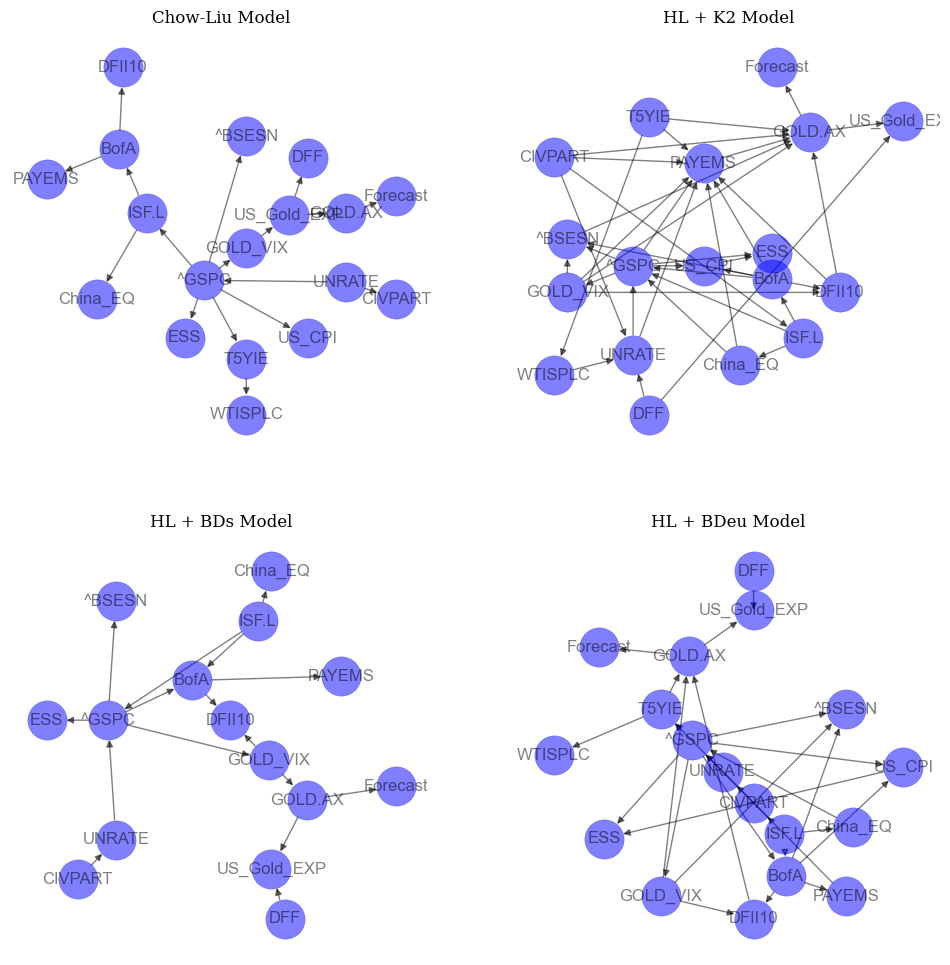

In [56]:
fig, ax = plt.subplots(2,2, figsize = (12,12))
G = [nx.DiGraph(CLF_Model.edges()), nx.DiGraph(K2F_Model.edges()), nx.DiGraph(BDsF_Model.edges()), nx.DiGraph(BDeuF_Model.edges())]
G_Titles = ['Chow-Liu Model', 'HL + K2 Model', 'HL + BDs Model', 'HL + BDeu Model']
for i in range(2):
    for j in range(2):
        Pos = nx.nx_agraph.graphviz_layout(G[2*(i)+j], prog="twopi", args="")
        nx.draw(G[2*(i)+j], Pos, node_size=800, alpha=0.5, node_color="blue", ax = ax[i,j], with_labels=True)
        ax[i,j].set_title(G_Titles[2*(i)+j], color = 'black')
plt.show()

In [10]:
CLF_Model.edges()

OutEdgeView([('UNRATE', 'CIVPART'), ('UNRATE', '^GSPC'), ('^GSPC', '^BSESN'), ('^GSPC', 'ISF.L'), ('^GSPC', 'GOLD_VIX'), ('^GSPC', 'ESS'), ('^GSPC', 'T5YIE'), ('^GSPC', 'US_CPI'), ('ISF.L', 'BofA'), ('ISF.L', 'China_EQ'), ('GOLD_VIX', 'US_Gold_EXP'), ('T5YIE', 'WTISPLC'), ('BofA', 'DFII10'), ('BofA', 'PAYEMS'), ('US_Gold_EXP', 'GOLD.AX'), ('US_Gold_EXP', 'DFF'), ('GOLD.AX', 'Forecast')])

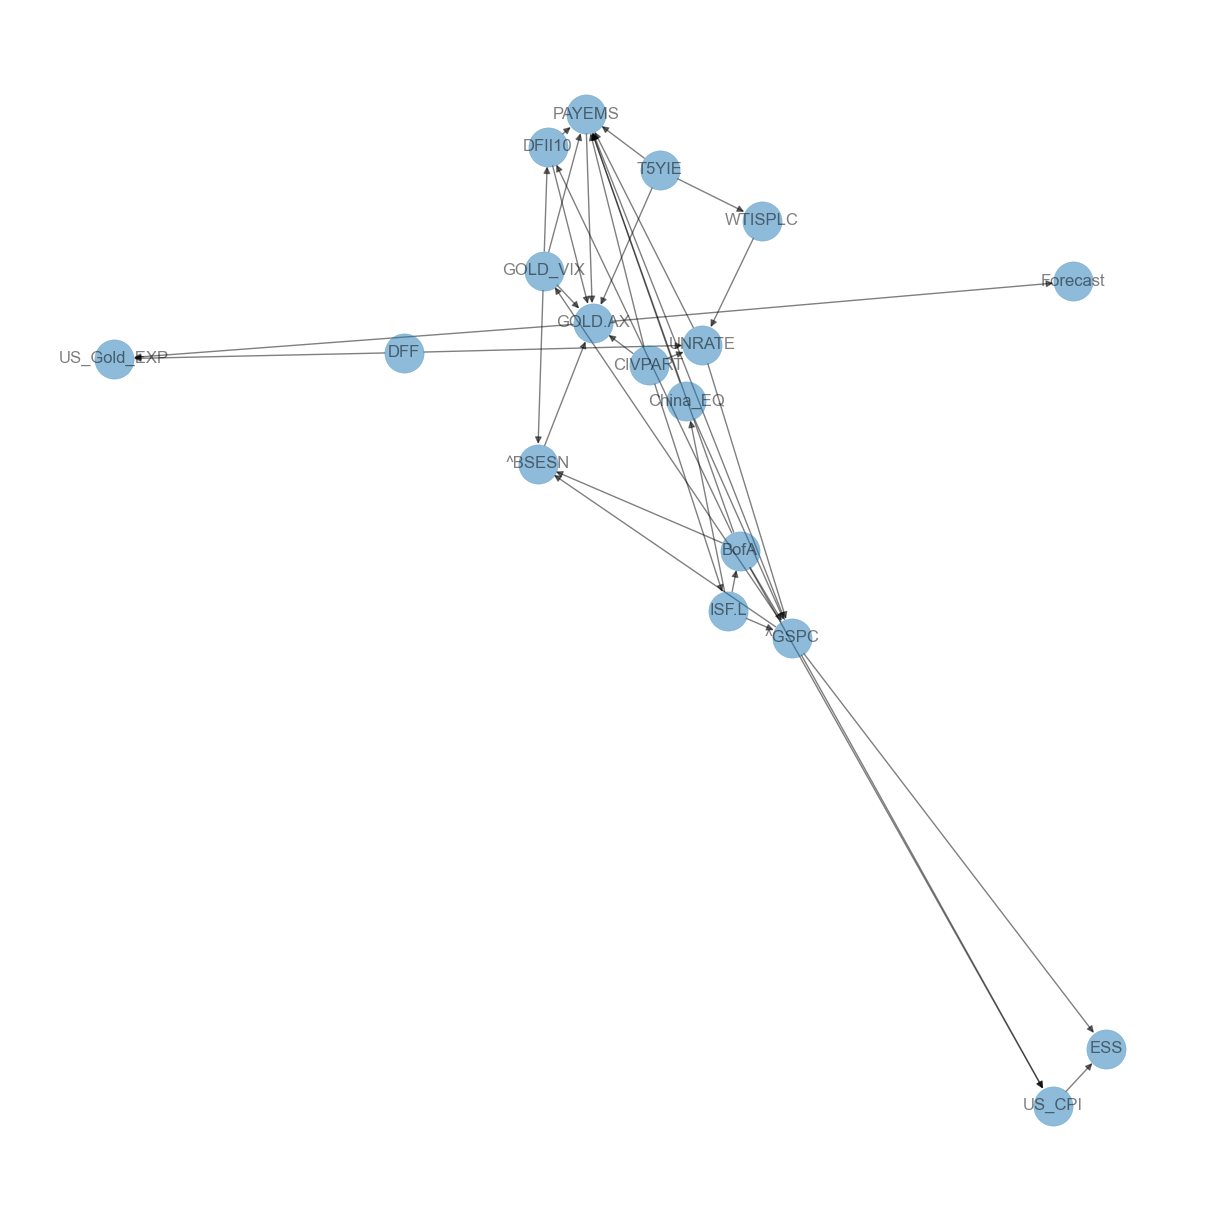

In [5]:
nx.draw(nx.DiGraph(K2F_Model.edges()), node_size = 800, alpha = 0.5, with_labels=True)
plt.rcParams['figure.figsize'] = [12,12]
plt.show()

<b>Model Evaluation | Training</b>

In [22]:
from pgmpy.metrics import log_likelihood_score, correlation_score
from pgmpy.metrics import structure_score

In [57]:
with open('C:/MScFE/Capstone/Models/BayesianCL.pkl', 'rb') as file:
    Bayesian_CLF_Model = pickle.load(file)
with open('C:/MScFE/Capstone/Models/BayesianK2.pkl', 'rb') as file:
    Bayesian_K2F_Model = pickle.load(file)
with open('C:/MScFE/Capstone/Models/BayesianBDs.pkl', 'rb') as file:
    Bayesian_BDsF_Model = pickle.load(file)
with open('C:/MScFE/Capstone/Models/BayesianBDeu.pkl', 'rb') as file:
    Bayesian_BDeuF_Model = pickle.load(file)

In [ ]:
pd.DataFrame({'Bayesian_CL_Model':[log_likelihood_score(Bayesian_CLF_Model, DiscreteF_DF_),
                                  correlation_score(Bayesian_CLF_Model, DiscreteF_DF_, test = 'chi_square')],
             'Bayesian_BDeu_Model':[log_likelihood_score(Bayesian_BDeuF_Model, DiscreteF_DF_),
                                  correlation_score(Bayesian_BDeuF_Model, DiscreteF_DF_, test = 'chi_square')],
             'Bayesian_K2_Model':[log_likelihood_score(Bayesian_K2F_Model, DiscreteF_DF_),
                                  correlation_score(Bayesian_K2F_Model, DiscreteF_DF_, test = 'chi_square')],
             'Bayesian_BDs_Model':[log_likelihood_score(Bayesian_BDsF_Model, DiscreteF_DF_),
                                  correlation_score(Bayesian_BDsF_Model, DiscreteF_DF_, test = 'chi_square')],},
            index = ['LogLScore', 'F1-Score'])

<b>Validating Models</b>

In [58]:
# Choice K2F Model
# Predict using Bayesian_K2_Model, Pass DataFrame with only columns containing 'Observed' variables (States). 
# .predict method returns Value of the 'Inferred' variable, with the Highest Probability.
K2F_Model_V = Bayesian_K2F_Model.predict(DiscreteF_DF_V.iloc[:,:-1])
BDeuF_Model_V = Bayesian_BDeuF_Model.predict(DiscreteF_DF_V.iloc[:,:-1], stochastic = True)
CLF_Model_V = Bayesian_CLF_Model.predict(DiscreteF_DF_V.iloc[:,:-1], stochastic = True)
BDsF_Model_V = Bayesian_BDsF_Model.predict(DiscreteF_DF_V.iloc[:,:-1], stochastic = True)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [59]:
Gold_F_V= pd.DataFrame({'Gold Correct Forecast': DiscreteF_DF_V['Forecast'], 'Prediction K2 Model': K2F_Model_V['Forecast'].values,
              'Prediction BDeu Model': BDeuF_Model_V['Forecast'].values,'Prediction Chow-Liu Model': CLF_Model_V['Forecast'].values,
            'Prediction BDs Model': BDsF_Model_V['Forecast'].values}, 
             index=DiscreteF_DF_V.index[-len(K2F_Model_V):])
Gold_F_V.T

DateTime,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01
Gold Correct Forecast,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
Prediction K2 Model,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
Prediction BDeu Model,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
Prediction Chow-Liu Model,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
Prediction BDs Model,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [60]:
# Accuracy of Validation Set
pd.DataFrame(np.array([np.mean(Gold_F_V['Gold Correct Forecast'] == Gold_F_V[i].values) for i in Gold_F_V.columns[1:]]),
            index = Gold_F_V.columns[1:], columns = ['Accuracy']).T

,Prediction K2 Model,Prediction BDeu Model,Prediction Chow-Liu Model,Prediction BDs Model
Accuracy,0.583333,0.5,0.75,0.75


<b>Testing</b>

In [31]:
Bayesian_K2F_Model = pickle.load(open('C:/MScFE/Capstone/Models/BayesianK2.pkl', 'rb'))

In [ ]:
# Predict using Bayesian_K2_Model, Pass DataFrame with only columns containing 'Observed' variables (States). 
# .predict method returns Value of the 'Inferred' variable, with the Highest Probability.
K2F_Model_T = Bayesian_K2F_Model.predict(DiscreteF_DF_T.iloc[:,:-1])
BDeuF_Model_T = Bayesian_BDeuF_Model.predict(DiscreteF_DF_T.iloc[:,:-1], stochastic = True)
CLF_Model_T = Bayesian_CLF_Model.predict(DiscreteF_DF_T.iloc[:,:-1], stochastic = True)
BDsF_Model_T = Bayesian_BDsF_Model.predict(DiscreteF_DF_T.iloc[:,:-1], stochastic = True)

In [66]:
Gold_F_T= pd.DataFrame({'Gold Correct Forecast': DiscreteF_DF_T['Forecast'], 'Prediction K2 Model': K2F_Model_T['Forecast'].values,
              'Prediction BDeu Model': BDeuF_Model_T['Forecast'].values,'Prediction Chow-Liu Model': CLF_Model_T['Forecast'].values,
            'Prediction BDs Model': BDsF_Model_T['Forecast'].values}, 
             index=DiscreteF_DF_T.index[-len(K2F_Model_T):])
Gold_F_T.T

DateTime,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
Gold Correct Forecast,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
Prediction K2 Model,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
Prediction BDeu Model,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
Prediction Chow-Liu Model,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
Prediction BDs Model,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [67]:
# Accuracy of Testing Set
pd.DataFrame(np.array([np.mean(Gold_F_T['Gold Correct Forecast'] == Gold_F_T[i].values) for i in Gold_F_T.columns[1:]]),
            index = Gold_F_T.columns[1:], columns = ['Accuracy']).T

,Prediction K2 Model,Prediction BDeu Model,Prediction Chow-Liu Model,Prediction BDs Model
Accuracy,0.75,0.583333,0.75,0.25


In [68]:
BDsF_Model.edges()

OutEdgeView([('US_Gold_EXP', 'GOLD.AX'), ('BofA', 'DFII10'), ('BofA', 'PAYEMS'), ('BofA', 'GOLD.AX'), ('^BSESN', '^GSPC'), ('ISF.L', 'BofA'), ('ISF.L', 'China_EQ'), ('^GSPC', 'ISF.L'), ('^GSPC', 'GOLD_VIX'), ('^GSPC', 'ESS'), ('^GSPC', 'BofA'), ('GOLD.AX', 'Forecast'), ('DFII10', 'US_Gold_EXP'), ('GOLD_VIX', 'US_Gold_EXP'), ('GOLD_VIX', 'DFII10'), ('UNRATE', '^GSPC'), ('UNRATE', 'CIVPART')])

<b>Portfolio Performance Measurement | Testing</b>

In [24]:
SA_C_Weights = np.array([0.25, .22, 0.0, 0.0, 0.0, 0.0, 0.53])
TAA_C_Weights = np.array([0.25, .15, 0.10, 0.0, 0.0, 0.0, 0.50])
TAA_A_Weights = np.array([0.45, .15, 0.0, 0.0, 0.0, 0.0, 0.40])
TAA_A2_Weights = np.array([0.55, .15, 0.0, 0.0, 0.0, 0.0, 0.30])

In [25]:
# Return of Portfolio with 1/N Diversification
wn = np.array([1/len(ER) for i in range(len(ER))]).reshape(-1,1)

In [33]:
# Take the Indices of Test + Last Date (13 Records)
Asset_P_IDX = list(DiscreteF_DF_T.index) + [Combine_R_DF.index[-1]]

In [34]:
D_IDX = {i:[] for i in SPDR_DF_T.columns}
D_IDX_Keys = D_IDX.keys()
for i in Asset_P_IDX:
    if i in SPDR_DF_.index:
        for j in D_IDX_Keys:
            D_IDX[j].append(SPDR_DF_.loc[i][j])
    else :
        if i.month == 1:
            T = SPDR_DF_.loc[[k.month ==12 and k.year == i.year -1 for k in SPDR_DF_.index]].iloc[-1,]
        else :
            T = SPDR_DF_.loc[[k.month ==i.month -1 and k.year == i.year for k in SPDR_DF_.index]].iloc[-1,]
        for j in D_IDX_Keys:
            D_IDX[j].append(T[j])
SPDRm_DF_T = pd.DataFrame(D_IDX, index = Asset_P_IDX)

In [39]:
N_R_ = ReturnsPerClose(SPDRm_DF_T)

In [69]:
N_R_Prices = ReturnsPerClose(SPDR_DF_T)
N_R_C = N_R_Prices.corr()
P2 = (SPDR_DF_T.index[-1] - SPDR_DF_T.index[0]).days/365
# Get Expected Return and Volatility Standard Deviation of Returns Per Close
NP_ER = N_R_Prices.sum(axis = 0)
NP_STD = N_R_Prices.std(axis = 0)
#Annualized STD/Volatility
NP_Y_STD = NP_STD*math.sqrt(P2*365)
NP_Y_ER = N_R_Prices.sum(axis = 0)/P2

In [27]:
def TAARebalance(SA, TA, F, P, A):
    '''
    P: DataFrame/Array. M*N Prices. M Days/Periods and N Assets
    SA, TA: Array. Strategic and Tactical Asset Weights N*1 weights for N assets
    F: Signal Vector.Shape is M*1, M Periods. E.G. If F is 1 then TA, if F is 0 then SA
    A: Float. Intial Investment
    '''
    R = ReturnsPerClose(P)
    R_ = R.values
    S = np.zeros((F.shape[0]+1, SA.shape[0]))
    S[0,] = A*SA
    for i in range(len(F)):
        if F[i] == 1:
            S[i+1,] = np.sum(S[i,])*TA*np.exp(R_[i,])
        else:
            S[i+1,] = np.sum(S[i,])*SA*np.exp(R_[i,])
    return pd.DataFrame(np.sum(S, axis = 1), index = P.index, columns = ['Price'])

In [28]:
def TAARebalance_(SA, TA, F, P, A):
    '''
    P: DataFrame/Array. M*N Prices. M Days/Periods and N Assets
    SA, TA: Array. Strategic and Tactical Asset Weights N*1 weights for N assets
    F: Signal Vector.Shape is M*1, M Periods. E.G. If F is 1 then TA, if F is 0 then SA
    A: Float. Intial Investment
    '''
    R = ReturnsPerClose(P)
    R_ = R.values
    S = np.zeros((F.shape[0]+1, SA.shape[0]))
    S[0,] = A*SA
    for i in range(len(F)):
        if i ==0:
            if F[i] == 1:
                S[i+1,] = np.sum(S[i,])*TA*np.exp(R_[i,])
            else:
                S[i+1,] = np.sum(S[i,])*SA*np.exp(R_[i,])
        else:
            if F[i] == 1:
                if F[i-1] == 0:
                    S[i+1,] = np.sum(S[i,])*TA*np.exp(R_[i,])
                else:
                    w_ = S[i,]/np.sum(S[i,])
                    S[i+1,] = np.sum(S[i,])*w_*np.exp(R_[i,])
            else:
                S[i+1,] = np.sum(S[i,])*SA*np.exp(R_[i,])
    return pd.DataFrame(np.sum(S, axis = 1), index = P.index, columns = ['Price'])

In [156]:
TAA_K2T_Price = TAARebalance(SA_C_Weights, TAA_C_Weights, K2F_Model_T['Forecast'].values, SPDRm_DF_T, 100)
TAA_BDsT_Price = TAARebalance(SA_C_Weights, TAA_C_Weights, BDsF_Model_T['Forecast'].values, SPDRm_DF_T, 100)

In [43]:
# Conservative
TAA1_K2T_Price = TAARebalance_(SA_C_Weights, TAA_C_Weights, K2F_Model_T['Forecast'].values, SPDRm_DF_T, 100)
# Moderate Tactical Asset Allocation
TAA1_K2TA_Price = TAARebalance_(SA_C_Weights, TAA_A_Weights, K2F_Model_T['Forecast'].values, SPDRm_DF_T, 100)
# Aggressive Tactical Asset Allocation
TAA1_K2TA2_Price = TAARebalance_(SA_C_Weights, TAA_A2_Weights,K2F_Model_T['Forecast'].values, SPDRm_DF_T, 100)

In [157]:
# Moderate Tactical Asset Allocation
TAA_K2TA_Price = TAARebalance(SA_C_Weights, TAA_A_Weights, K2F_Model_T['Forecast'].values, SPDRm_DF_T, 100)
TAA_BDsTA_Price = TAARebalance(SA_C_Weights, TAA_A_Weights, BDsF_Model_T['Forecast'].values, SPDRm_DF_T, 100)
# Aggressive Tactical Asset Allocation
TAA_K2TA2_Price = TAARebalance(SA_C_Weights, TAA_A2_Weights,K2F_Model_T['Forecast'].values, SPDRm_DF_T, 100)
TAA_BDsTA2_Price = TAARebalance(SA_C_Weights,TAA_A2_Weights,BDsF_Model_T['Forecast'].values, SPDRm_DF_T, 100)

In [37]:
N_Rm_Prices = ReturnsPerClose(SPDRm_DF_T)
TAA_T_Price = TAARebalance(SA_C_Weights, TAA_C_Weights, K2F_Model_T['Forecast'].values, SPDRm_DF_T, 100)

In [40]:
NR_SA_Price = pd.DataFrame(100, columns = ['Price'], index = [TAA_T_Price.index[0]]).append(NoRebalance(N_R_, SA_C_Weights.reshape(-1,1), 100))
NR_Naive_Price = pd.DataFrame(100, columns = ['Price'], index = [TAA_T_Price.index[0]]).append(NoRebalance(N_R_, wn, 100))

In [46]:
DR_SA_Price = pd.DataFrame(100, columns = ['Price'], index = [TAA_T_Price.index[0]]).append(DailyRebalance(N_R_, SA_C_Weights, 100))

In [164]:
AA_Models = [TAA_K2T_Price, TAA_BDsT_Price, TAA_K2TA_Price, TAA_BDsTA_Price,TAA_K2TA2_Price,TAA_BDsTA2_Price, DR_SA_Price, NR_SA_Price, NR_Naive_Price]
AA_Names = ['TAA Conservative K2', 'TAA Conservative BDs', 'TAA MOD K2', 'TAA MOD BDs','TAA AGG K2', 'TAA AGG BDs', 'Strategic AA K2 Monthly RB', 'Strategic AA K2 No RB', 'Naive No RB']
RMSE_R_T = {i:[] for i in AA_Names}
for i in range(len(AA_Models)):
    RMSE_R_T[AA_Names[i]].append(np.round(ReturnsPerClose(AA_Models[i]).std()[0]*math.sqrt(12),4))
RMSE_R_DF_T = pd.DataFrame(RMSE_R_T, index = ['Volatility'])
R1 = sorted([(i, RMSE_R_DF_T[i][0]) for i in RMSE_R_DF_T.columns],key = lambda t : t[1], reverse = False)
Ranked_RMSE_DF = pd.DataFrame(np.array(R1).T[1:], index = ['Volatility'], columns = [i[0] for i in R1])
Ranked_RMSE_DF

,TAA Conservative BDs,TAA Conservative K2,TAA MOD BDs,Strategic AA K2 No RB,TAA AGG BDs,Naive No RB,Strategic AA K2 Monthly RB,TAA MOD K2,TAA AGG K2
Volatility,0.1184,0.1187,0.1192,0.1193,0.1196,0.1208,0.122,0.1221,0.124


In [151]:
ReturnsPerClose(AA_Models[1]).sum()[0]

-0.08400271449744157

In [152]:
Portfolio_R_T = {i:[] for i in AA_Names}
for i in range(len(AA_Models)):
    Portfolio_R_T[AA_Names[i]].append(np.round(ReturnsPerClose(AA_Models[i]).sum()[0],4)-0.02)
Portfolio_R_DF_T = pd.DataFrame(Portfolio_R_T, index = ['Excess Returns'])

In [153]:
Portfolio_R_DF_T

,TAA Conservative K2,TAA Conservative BDs,TAA MOD K2,TAA MOD BDs,TAA AGG K2,TAA AGG BDs,Strategic AA K2 Monthly RB,Strategic AA K2 No RB,Naive No RB
Excess Returns,-0.1076,-0.104,-0.095,-0.0764,-0.0949,-0.0825,-0.1241,-0.1261,-0.164


In [123]:
pd.DataFrame(Portfolio_R_DF_T.values/(RMSE_R_DF_T.values*math.sqrt(12)))

,0,1,2,3,4,5,6,7,8
0,-1.073347,-1.204412,-1.075423,-1.137027,-0.756775,-0.686331,-1.017744,-1.055129,-1.356525


In [154]:
SR_R_DF_T = pd.DataFrame(np.round(Portfolio_R_DF_T.values/(RMSE_R_DF_T.values*math.sqrt(12)),3), columns = AA_Names, index = ['Sharpe-Ratio'])
R2 = sorted([(i, SR_R_DF_T[i][0]) for i in SR_R_DF_T.columns],key = lambda t : t[1], reverse = True)
Ranked_SR_DF = pd.DataFrame(np.array(R2).T[1:], index = ['Sharpe-Ratio'], columns = [i[0] for i in R2])
Ranked_SR_DF

,TAA MOD BDs,TAA AGG BDs,TAA AGG K2,TAA MOD K2,TAA Conservative BDs,TAA Conservative K2,Strategic AA K2 Monthly RB,Strategic AA K2 No RB,Naive No RB
Sharpe-Ratio,-0.641,-0.686,-0.757,-0.779,-0.878,-0.906,-1.018,-1.055,-1.357


In [ ]:
# K2 model can perform TAA and achieve a higher Sharpe Ratio out-of-sample, consistently in a Bear Market

In [129]:
DiscreteF_DF_V.iloc[:,:-1].columns

Index(['WTISPLC', 'US_Gold_EXP', 'BofA', '^BSESN', 'China_EQ', 'ISF.L', 'ESS',
       '^GSPC', 'GOLD.AX', 'DFF', 'DFII10', 'T5YIE', 'GOLD_VIX', 'CIVPART',
       'PAYEMS', 'UNRATE', 'US_CPI'],
      dtype='object')

View Models in Kamada Kawai Layout

In [7]:
with open('C:/MScFE/Capstone/Models/BayesianCL.pkl', 'rb') as file:
    Bayesian_CLF_Model = pickle.load(file)
with open('C:/MScFE/Capstone/Models/BayesianK2.pkl', 'rb') as file:
    Bayesian_K2F_Model = pickle.load(file)
with open('C:/MScFE/Capstone/Models/BayesianBDs.pkl', 'rb') as file:
    Bayesian_BDsF_Model = pickle.load(file)
with open('C:/MScFE/Capstone/Models/BayesianBDeu.pkl', 'rb') as file:
    Bayesian_BDeuF_Model = pickle.load(file)

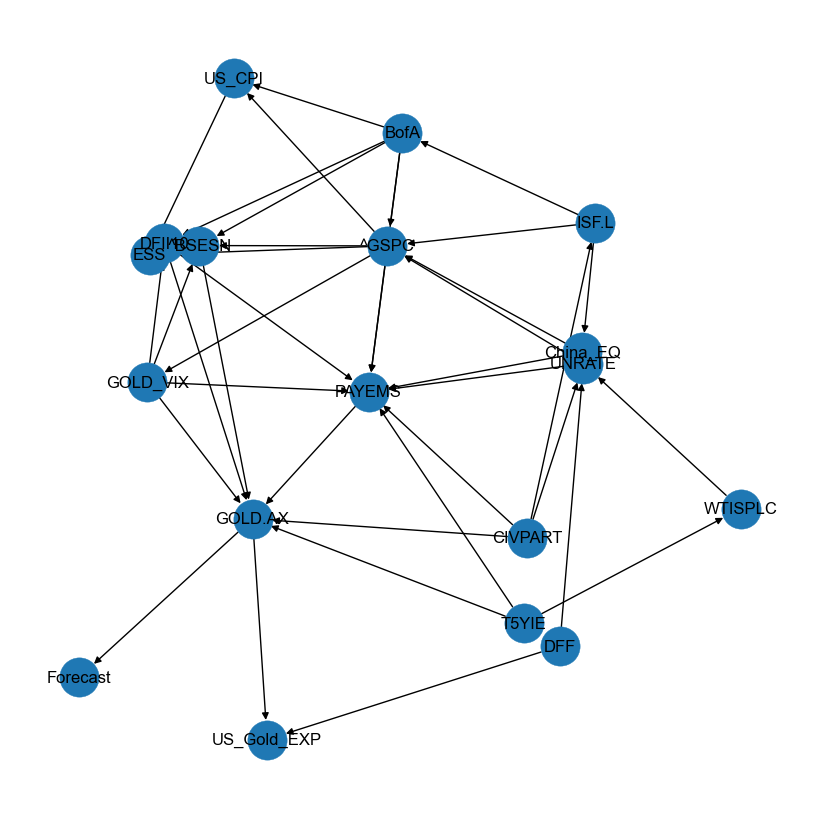

In [47]:
G_K2 = nx.DiGraph(Bayesian_K2F_Model.edges())
nx.draw(G_K2, pos = nx.kamada_kawai_layout(G_K2), node_size = 800, with_labels=True)
plt.rcParams['figure.figsize'] = [12,8]
plt.show()

<b>Chow-Liu Model</b>

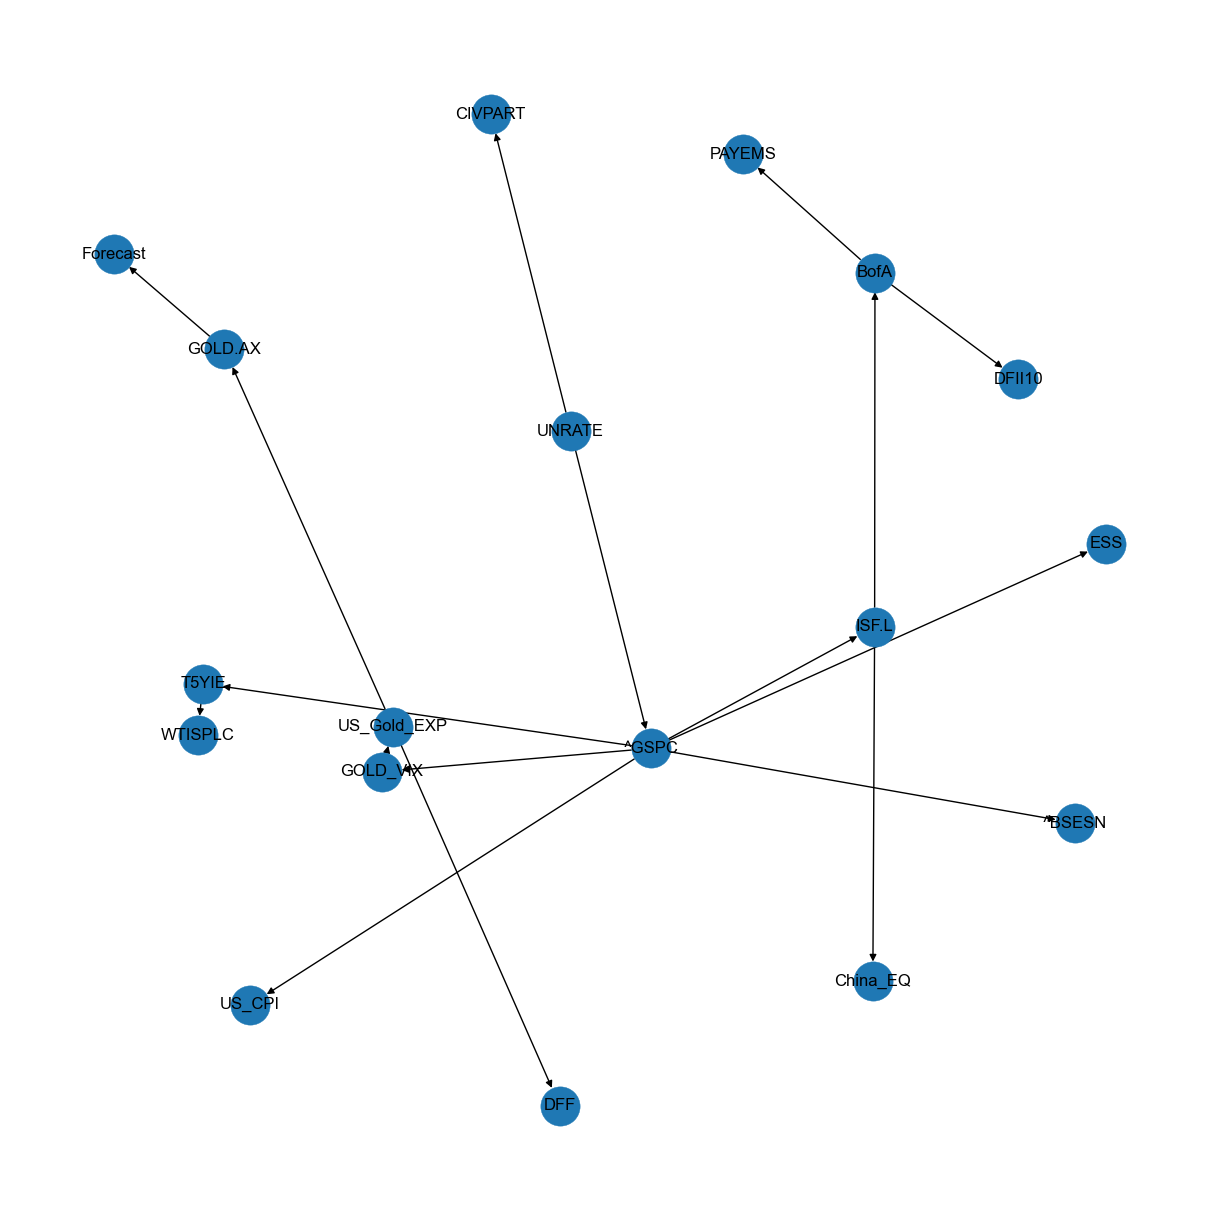

In [13]:
nx.draw(nx.DiGraph(CLF_Model.edges()), node_size = 800, with_labels=True)
plt.rcParams['figure.figsize'] = [12,12]
plt.show()

<b>BDs Model</b>

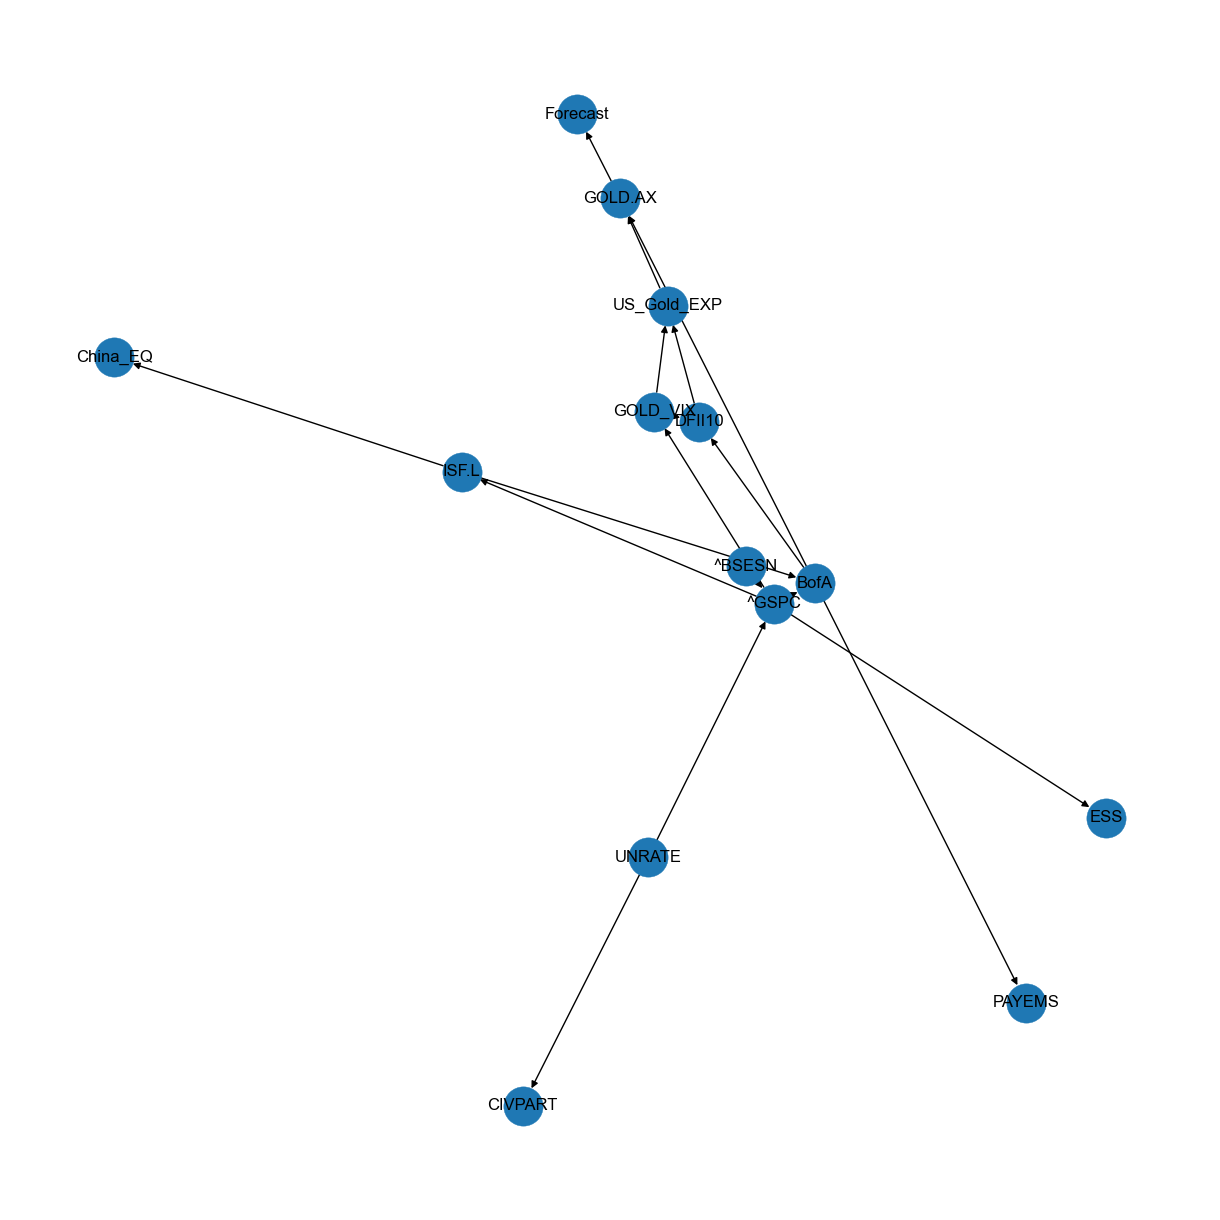

In [14]:
nx.draw(nx.DiGraph(BDsF_Model.edges()), node_size = 800, with_labels=True)
plt.rcParams['figure.figsize'] = [12,12]
plt.show()

<b>BDeu Model</b>

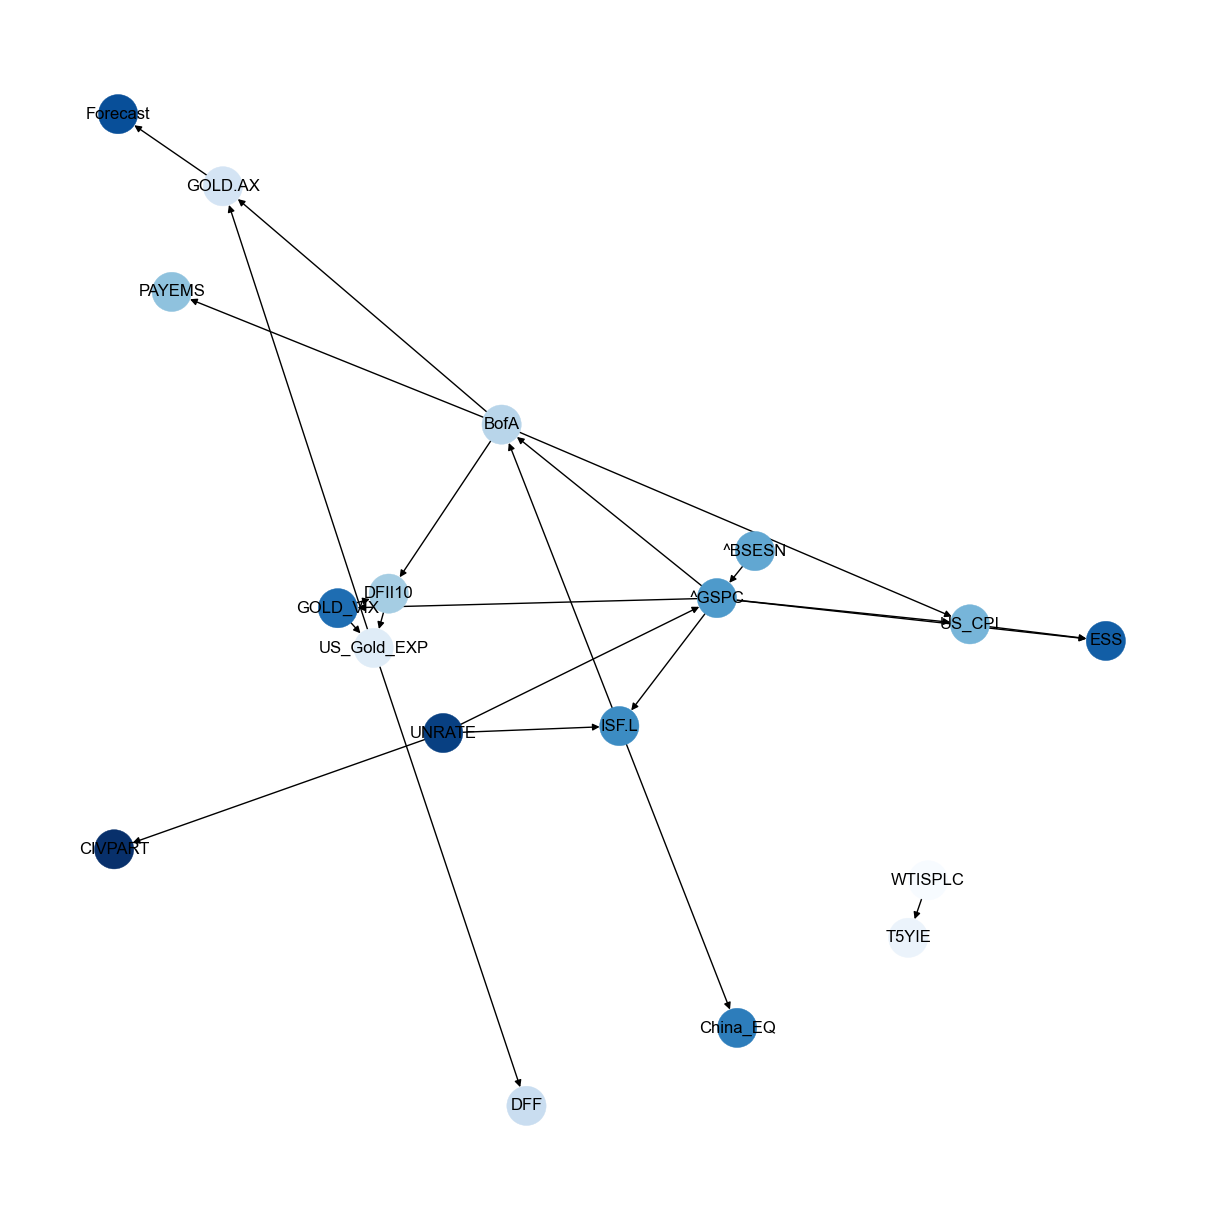

In [24]:
nx.draw(nx.DiGraph(BDeuF_Model.edges()), node_color = range(18), cmap=plt.cm.Blues, node_size = 800, with_labels=True)
plt.rcParams['figure.figsize'] = [12,12]
plt.show()

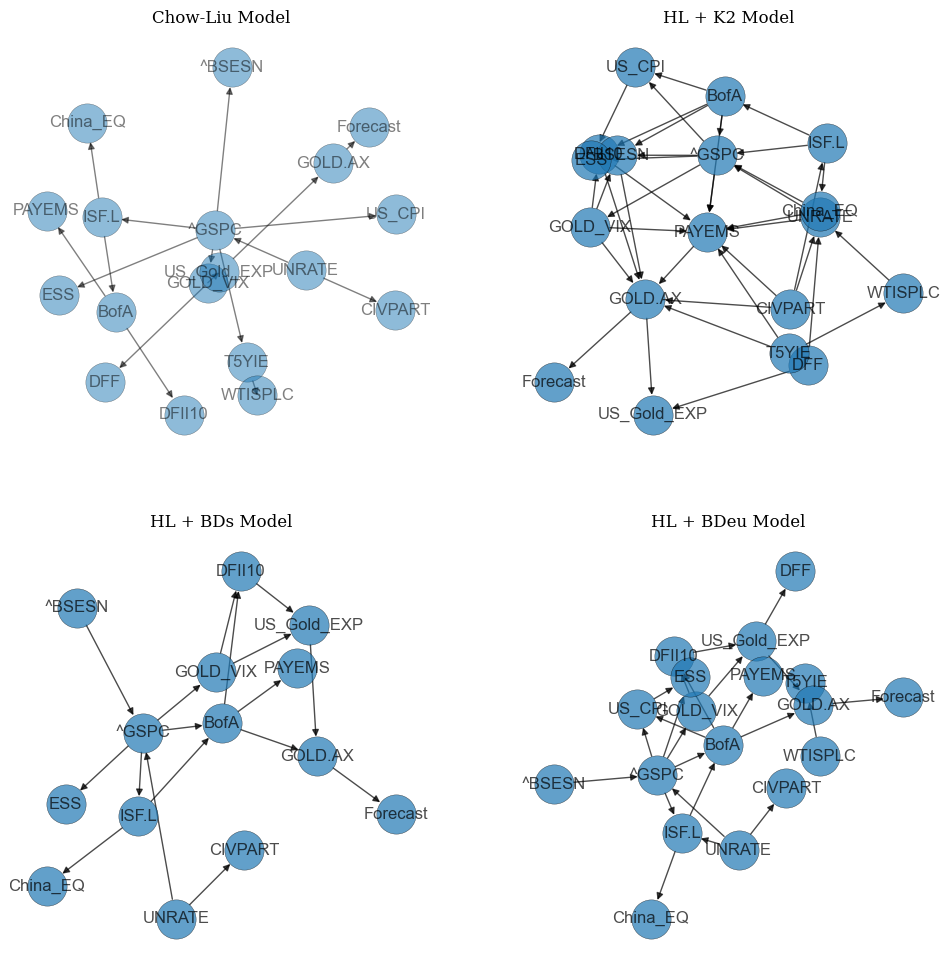

In [9]:
fig, ax = plt.subplots(2,2, figsize = (12,12))
G1 = [nx.DiGraph(Bayesian_CLF_Model.edges()), nx.DiGraph(Bayesian_K2F_Model.edges()), nx.DiGraph(Bayesian_BDsF_Model.edges()), nx.DiGraph(Bayesian_BDeuF_Model.edges())]
G_Titles = ['Chow-Liu Model', 'HL + K2 Model', 'HL + BDs Model', 'HL + BDeu Model']
for i in range(2):
    for j in range(2):
        if i == 0 and j == 0:
            nx.draw(G1[2*(i)+j], node_size = 800, edgecolors = 'k', ax = ax[i,j], alpha=0.5, with_labels=True)
            ax[i,j].set_title(G_Titles[2*(i)+j], color = 'black')    
        else:
            nx.draw(G1[2*(i)+j], pos = nx.kamada_kawai_layout(G1[2*(i)+j]), node_size = 800, alpha =0.7, edgecolors = 'k', ax = ax[i,j], with_labels=True)
            ax[i,j].set_title(G_Titles[2*(i)+j], color = 'black')
plt.show()

In [32]:
AVG_OutD = [len(i.edges())/len(i.nodes()) for i in G1]

In [42]:
N_Nodes, N_Edges = [len(i.nodes()) for i in G1], [len(i.edges()) for i in G1]

In [43]:
pd.DataFrame([N_Nodes, N_Edges, AVG_OutD], index = ['Number of Nodes', 'Number of Out Edges', 'Average Out Degree'], columns = G_Titles)

,Chow-Liu Model,HL + K2 Model,HL + BDs Model,HL + BDeu Model
Number of Nodes,18.000000,18.000000,14.000000,18.000000
Number of Out Edges,17.000000,38.000000,17.000000,23.000000
Average Out Degree,0.944444,2.111111,1.214286,1.277778
